Adding monotonicity constraints to clean interactions and effects

**Table of contents**<a id='toc0_'></a>    
- [Process inputs](#toc1_)    
- [Read and Prep data](#toc2_)    
- [Create models](#toc3_)    
  - [Train model limiting no interaction](#toc3_1_)    
    - [Predict and evaluate](#toc3_1_1_)    
  - [Train model 2nd layer to just find 2 way interactions](#toc3_2_)    
    - [Evaluate](#toc3_2_1_)    
  - [Train 3 model and evaluate](#toc3_3_)    
- [Feature importance](#toc4_)    
  - [Feature importance main effects](#toc4_1_)    
  - [Feature importance 2 way interactions](#toc4_2_)    
  - [Feature importance 3 way interactions](#toc4_3_)    
- [Model Iterrogation](#toc5_)    
  - [Calc shap values](#toc5_1_)    
- [Contribution plots](#toc6_)    
- [Interaction analysis](#toc7_)    
  - [Main interactions](#toc7_1_)    
  - [Interaction plots](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import lightgbm as lgb
from func import calculate_prediction_quality, calculate_ranking_metrics, get_feature_importance

# <a id='toc1_'></a>[Process inputs](#toc0_)

In [5]:
target = 'qualidade_global_media_dada_pela_equipe'
categorical_features = ['laboratorio', 'fora_de_tipo_x_tipo_unico']
data_path = "../data/processed/df_model_v02.parquet"

# <a id='toc2_'></a>[Read and Prep data](#toc0_)

In [6]:
data = pd.read_parquet(data_path)

# Turn categorical variables to categorical type for lightgbm split variables as categorical
for cat_var in categorical_features:
    data[cat_var] = pd.Categorical(data[cat_var])

# Isolate and remove response column from data
response = data[target].values
trn_data = data.drop(columns=[target])

predictors = trn_data.columns
# Create lgbm dataset
trn_dset = lgb.Dataset(trn_data, label=response, params={'max_bin': 5000})

# <a id='toc3_'></a>[Create models](#toc0_)

## <a id='toc3_1_'></a>[Train model limiting no interaction](#toc0_)

In [7]:
predictors

Index(['laboratorio', 'fora_de_tipo_x_tipo_unico', 'odor_do_po', 'docura',
       'corpo', 'acidez_intensidade', 'acidez_qualidade', 'amargor',
       'adstringencia', 'intensidade', 'alcoolico',
       'cedro_carvalho_amadeirado', 'amendoado_castanhas', 'animalico_curral',
       'azedo', 'baunilha', 'borracha', 'caramelizado_caramelo_doce', 'cereal',
       'chocolate_cacau', 'cozido_assado', 'especiarias', 'fermentado',
       'floral', 'frutado', 'iodoformio_quimico', 'madeira_papelao', 'mel',
       'queimado_defumado', 'terroso_mofo', 'tostado', 'vegetal',
       'velho_oxidado', 'verde', 'herbaceo'],
      dtype='object')

In [19]:
mono_dict = {
    "docura":1, 
    "acidez_qualidade":1, 
    "intensidade":-1,
    "adstringencia":-1,
    "corpo":1,
    "baunilha":1,
    # "queimado_defumado":1,
    "fermentado":1,
    "chocolate_cacau":1,
    "cedro_carvalho_amadeirado":1,
    "terroso_mofo":-1,
    # "madeira_papelao":1,
    "azedo":-1,
    "velho_oxidado":1,
    "caramelizado_caramelo_doce":1,
    "vegetal":1,
    "verde":-1,
    # "especiarias":1,
    "iodoformio_quimico":-1,
    "borracha":-1,
    "cereal":1,
}
mono_list = [mono_dict[p] if p in mono_dict else 0 for p in predictors]

In [20]:
mdl = lgb.train(params={"objective":"regression", 
                        "num_boost_round":10000, 
                        "max_depth":1, 
                        "learning_rate":.05,
                        'max_bin': 5000,
                        "verbose":-1,
                        "monotone_constraints":mono_list
                        }, train_set=trn_dset)

/Users/caiosainvallio/miniconda3/envs/coffeetree/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### <a id='toc3_1_1_'></a>[Predict and evaluate](#toc0_)

In [21]:
prd = mdl.predict(trn_data)
calculate_prediction_quality(list(response),list(prd))

{'rmse': 0.16060243085948842,
 'mae': 0.11731032250683,
 'r2': 0.9862473858196357,
 'gini': 0.12551099329580095}

## <a id='toc3_2_'></a>[Train model 2nd layer to just find 2 way interactions](#toc0_)

In [22]:
int_dset = lgb.Dataset(trn_data, label=response, init_score=prd)

int_mdl = lgb.train(params={"objective":"regression",
                            "num_boost_round":10000, 
                            "max_depth":2, 
                            "learning_rate":1, 
                            "extra_trees" :True,
                            "verbose":-1}, 
                            train_set=int_dset)

/Users/caiosainvallio/miniconda3/envs/coffeetree/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### <a id='toc3_2_1_'></a>[Evaluate](#toc0_)

In [23]:
int_prd = int_mdl.predict(trn_data) + prd
calculate_prediction_quality(list(response),list(int_prd))

{'rmse': 0.002561629575402953,
 'mae': 0.0015705302203614878,
 'r2': 0.9999965012437438,
 'gini': 0.12658850028001778}

## <a id='toc3_3_'></a>[Train 3 model and evaluate](#toc0_)

In [24]:
int3_dset = lgb.Dataset(trn_data, label=response, init_score=int_prd)

int3_mdl = lgb.train(params={"objective":"regression", 
                            "num_boost_round":10000, 
                            "max_depth":3, 
                            "learning_rate":1, 
                            "extra_trees" :True,
                            "verbose":-1}, 
                            train_set=int3_dset)

/Users/caiosainvallio/miniconda3/envs/coffeetree/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [25]:
int3_prd = int3_mdl.predict(trn_data) + int_prd
calculate_prediction_quality(list(response),list(int3_prd))

{'rmse': 7.189304627322314e-06,
 'mae': 3.1656636609723234e-06,
 'r2': 0.9999999999724416,
 'gini': 0.12658850028001778}

In [26]:
calculate_ranking_metrics(list(response),list(int3_prd))

{'spearman_correlation': 0.9990010824674626,
 'kendall_tau': 0.9850360374331424,
 'ranking_error': 0.01484181262357025,
 'ordering_accuracy': 0.9725653015719907}

# <a id='toc4_'></a>[Feature importance](#toc0_)
## <a id='toc4_1_'></a>[Feature importance main effects](#toc0_)

In [27]:
main_imp = get_feature_importance(mdl,trn_data.columns)
main_imp

gain
Feature                         
acidez_intensidade          1719
amargor                     1650
docura                      1528
laboratorio                 1043
odor_do_po                  1032
intensidade                  723
queimado_defumado            349
frutado                      258
corpo                        246
madeira_papelao              193
acidez_qualidade             159
caramelizado_caramelo_doce   130
tostado                      111
fermentado                   104
verde                         82
floral                        73
baunilha                      70
terroso_mofo                  63
amendoado_castanhas           62
mel                           56
fora_de_tipo_x_tipo_unico     56
velho_oxidado                 52
borracha                      46
chocolate_cacau               43
vegetal                       33
cereal                        31
adstringencia                 31
cedro_carvalho_amadeirado     19
iodoformio_quimico            17
especiarias                   11
azedo                         10
cozido_assado                  0
animalico_curral               0
alcoolico                      0
herbaceo                       0

## <a id='toc4_2_'></a>[Feature importance 2 way interactions](#toc0_)

In [28]:
int_imp = get_feature_importance(int_mdl,trn_data.columns)
int_imp

gain
Feature                         
odor_do_po                  1899
intensidade                 1760
amargor                     1687
corpo                       1634
acidez_intensidade          1576
adstringencia               1523
docura                      1483
acidez_qualidade            1443
queimado_defumado           1362
velho_oxidado               1351
chocolate_cacau             1277
tostado                     1189
madeira_papelao             1119
laboratorio                 1058
caramelizado_caramelo_doce   876
frutado                      863
fora_de_tipo_x_tipo_unico    674
amendoado_castanhas          671
terroso_mofo                 586
verde                        544
borracha                     532
fermentado                   467
mel                          461
cedro_carvalho_amadeirado    459
cereal                       427
baunilha                     404
floral                       393
iodoformio_quimico           368
especiarias                  161
vegetal                      114
azedo                         66
animalico_curral               0
cozido_assado                  0
alcoolico                      0
herbaceo                       0

## <a id='toc4_3_'></a>[Feature importance 3 way interactions](#toc0_)

In [29]:
get_feature_importance(int3_mdl,trn_data.columns)

gain
Feature                         
velho_oxidado               4382
madeira_papelao             4314
chocolate_cacau             4049
queimado_defumado           3883
odor_do_po                  3551
tostado                     2920
intensidade                 2492
adstringencia               2455
acidez_intensidade          2440
corpo                       2378
amargor                     2307
acidez_qualidade            2121
docura                      2002
fora_de_tipo_x_tipo_unico   1676
frutado                     1676
caramelizado_caramelo_doce  1523
laboratorio                 1488
borracha                    1429
terroso_mofo                1069
iodoformio_quimico          1004
amendoado_castanhas          848
verde                        742
mel                          731
cedro_carvalho_amadeirado    659
floral                       561
baunilha                     527
cereal                       504
fermentado                   482
especiarias                  166
vegetal                      128
azedo                        124
alcoolico                      0
animalico_curral               0
cozido_assado                  0
herbaceo                       0

# <a id='toc5_'></a>[Model Iterrogation](#toc0_)

## <a id='toc5_1_'></a>[Calc shap values](#toc0_)

In [30]:
from shap import TreeExplainer

exp = TreeExplainer(mdl)
shap = exp.shap_values(trn_data)

shap_df = pd.DataFrame(shap, columns=trn_data.columns)
shap_df

laboratorio  fora_de_tipo_x_tipo_unico  odor_do_po    docura     corpo  \
0       0.092054                   0.027303   -0.026146  0.322979  0.138519   
1       0.092054                   0.027303   -0.024785  0.322979  0.213977   
2       0.092054                   0.027303   -0.004601  0.322979  0.138519   
3       0.092054                   0.027303   -0.004601  0.322979  0.213977   
4       0.092054                   0.027303   -0.039545  0.266255  0.138519   
..           ...                        ...         ...       ...       ...   
922    -0.417797                   0.027303   -0.079628 -0.011279 -0.187638   
923    -0.417797                   0.027303   -0.038247 -0.022260 -0.032031   
924    -0.417797                   0.027303   -0.039545 -0.011279 -0.032031   
925    -0.417797                   0.027303   -0.023748 -0.011279 -0.167499   
926    -0.417797                   0.027303    0.209646 -0.124926 -0.131407   

     acidez_intensidade  acidez_qualidade   amargor  adstringencia  \
0             -0.027673          0.768477  0.053640       0.316666   
1             -0.027673          0.768477  0.053640       0.316666   
2              0.010185          0.768477  0.014102       0.316666   
3              0.038246          0.845498 -0.046184       0.316666   
4             -0.055533          0.768477  0.014102       0.316666   
..                  ...               ...       ...            ...   
922            0.097885          0.103675  0.078307      -0.348048   
923            0.097885         -0.014424 -0.010375       0.094147   
924           -0.028408          0.103675  0.022423      -0.278303   
925           -0.028408          0.103675  0.005589      -0.313645   
926            0.097885         -0.251850  0.009971      -0.278303   

     intensidade  ...  iodoformio_quimico  madeira_papelao       mel  \
0       0.096923  ...            0.004109        -0.015281 -0.004226   
1       0.096923  ...            0.004109        -0.015281 -0.004226   
2       0.096923  ...            0.004109        -0.015281 -0.004226   
3       0.096923  ...            0.004109        -0.015281 -0.004226   
4       0.096923  ...            0.004109        -0.015281  0.027112   
..           ...  ...                 ...              ...       ...   
922     0.009367  ...            0.004109         0.036087 -0.004226   
923     0.096923  ...            0.004109        -0.015281 -0.004226   
924     0.096923  ...            0.004109         0.015673 -0.004226   
925     0.009367  ...            0.004109         0.038940 -0.004226   
926     0.068739  ...            0.004109        -0.015281 -0.004226   

     queimado_defumado  terroso_mofo   tostado   vegetal  velho_oxidado  \
0             0.001900      0.009508  0.000116 -0.001269      -0.002205   
1             0.001900      0.009508  0.000116 -0.001269      -0.002205   
2             0.001900      0.009508  0.000116 -0.001269      -0.002205   
3             0.001900      0.009508  0.000116 -0.001269      -0.002205   
4             0.001900      0.009508  0.000116 -0.001269      -0.002205   
..                 ...           ...       ...       ...            ...   
922           0.021861     -0.041991  0.000116 -0.001269      -0.002205   
923           0.021861      0.009508  0.000116 -0.001269      -0.002205   
924           0.006986     -0.041991  0.000116 -0.001269      -0.002205   
925           0.001900      0.009508  0.000116 -0.001269      -0.002205   
926           0.021861      0.009508  0.000116 -0.001269      -0.002205   

        verde  herbaceo  
0    0.008556       0.0  
1    0.008556       0.0  
2    0.008556       0.0  
3    0.008556       0.0  
4    0.008556       0.0  
..        ...       ...  
922  0.008556       0.0  
923  0.008556       0.0  
924  0.008556       0.0  
925  0.008556       0.0  
926  0.008556       0.0  

[927 rows x 35 columns]

# <a id='toc6_'></a>[Contribution plots](#toc0_)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


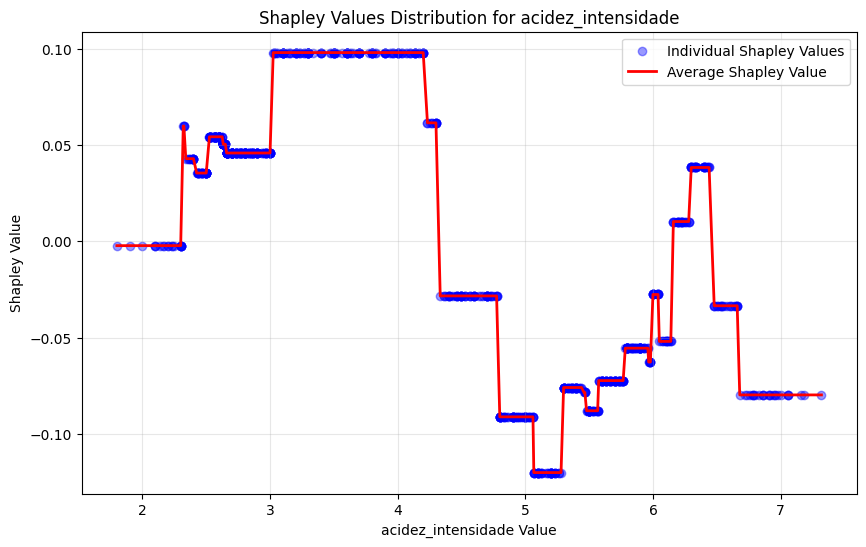

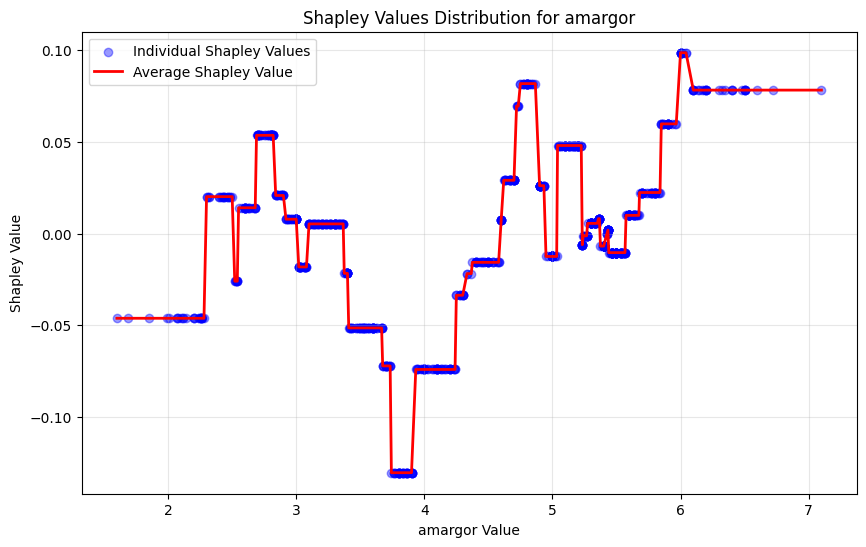

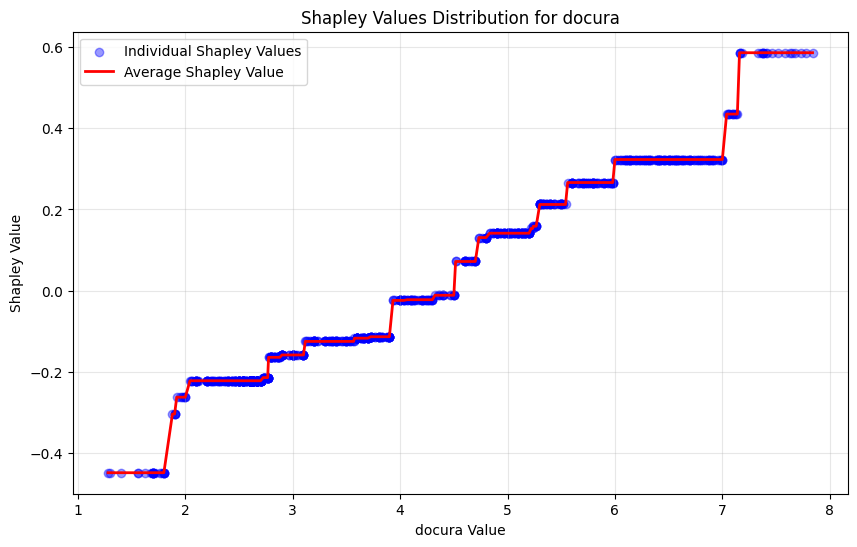

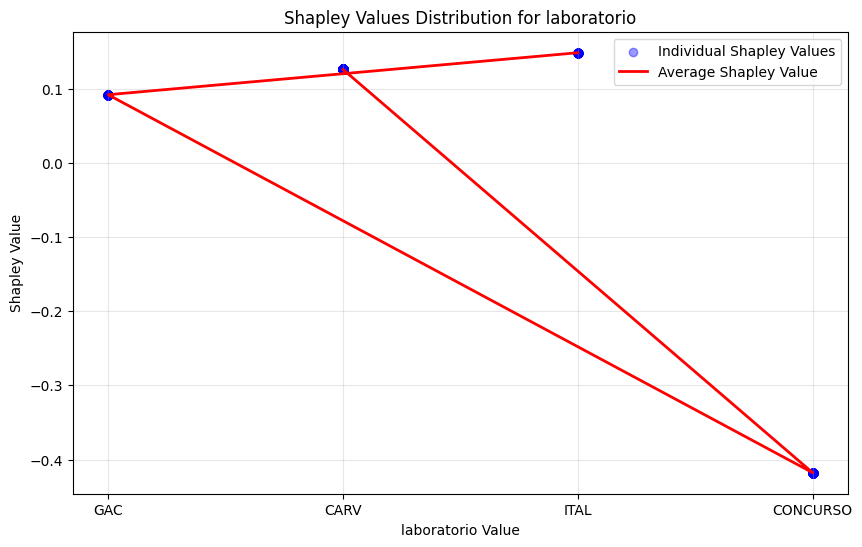

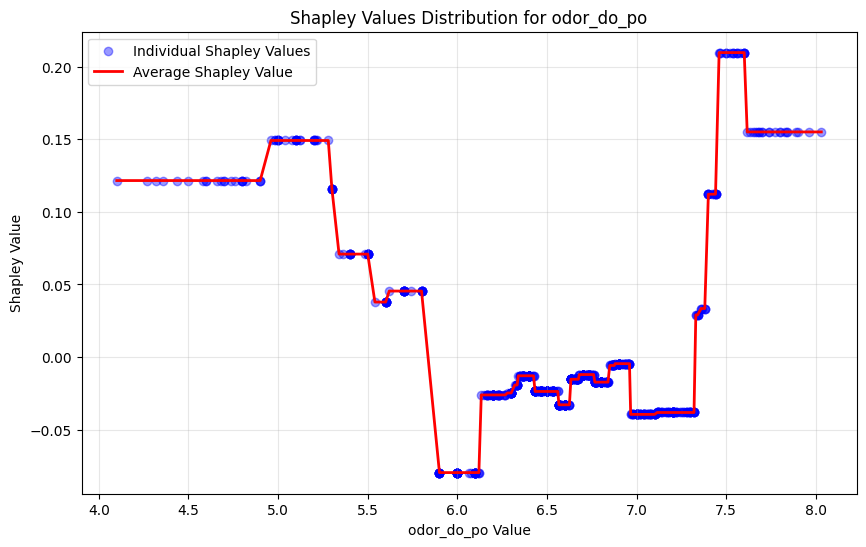

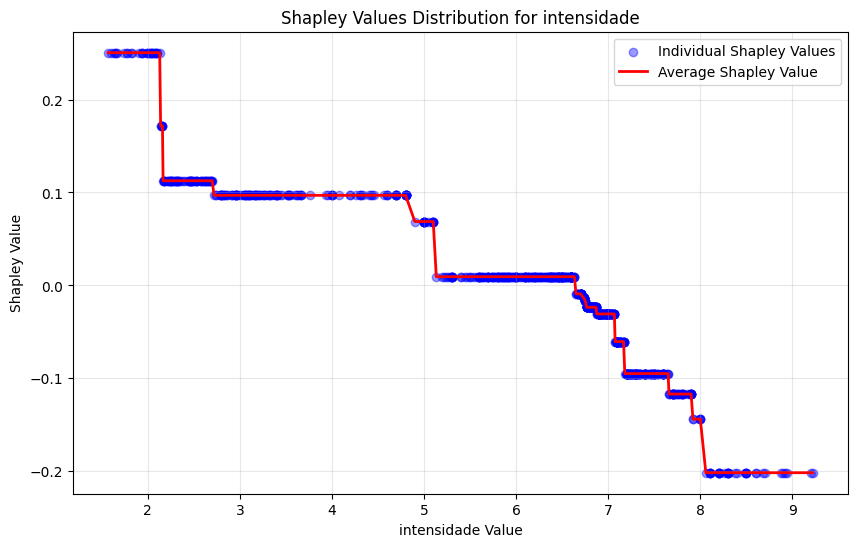

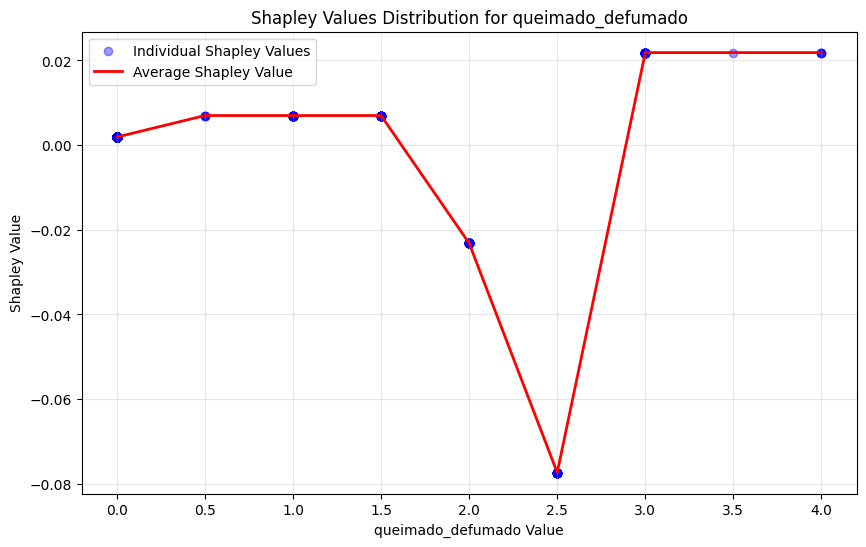

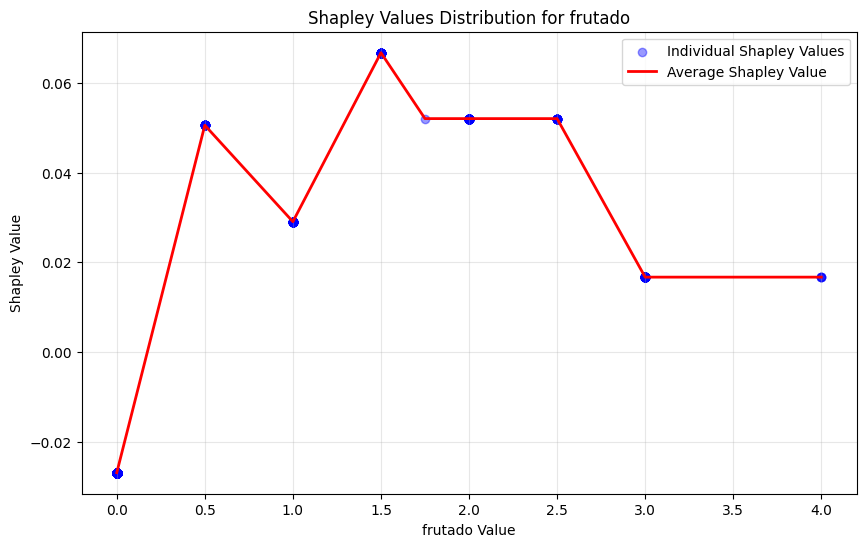

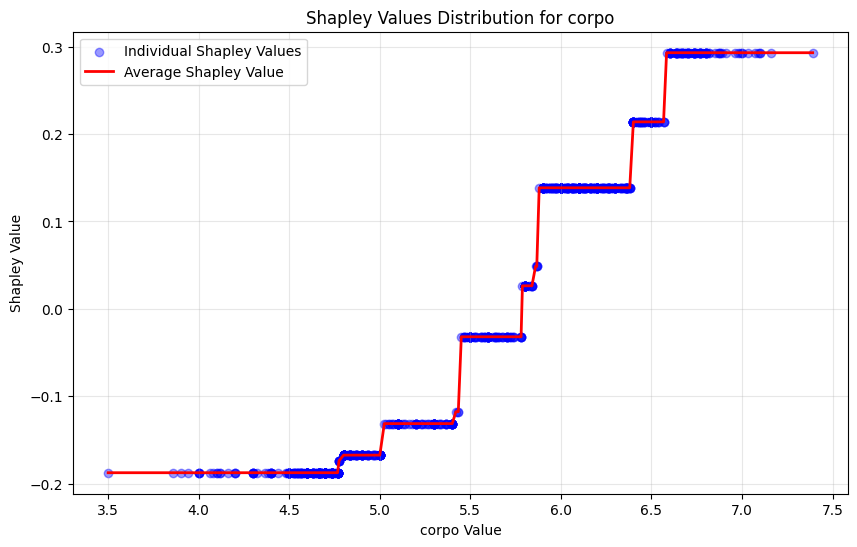

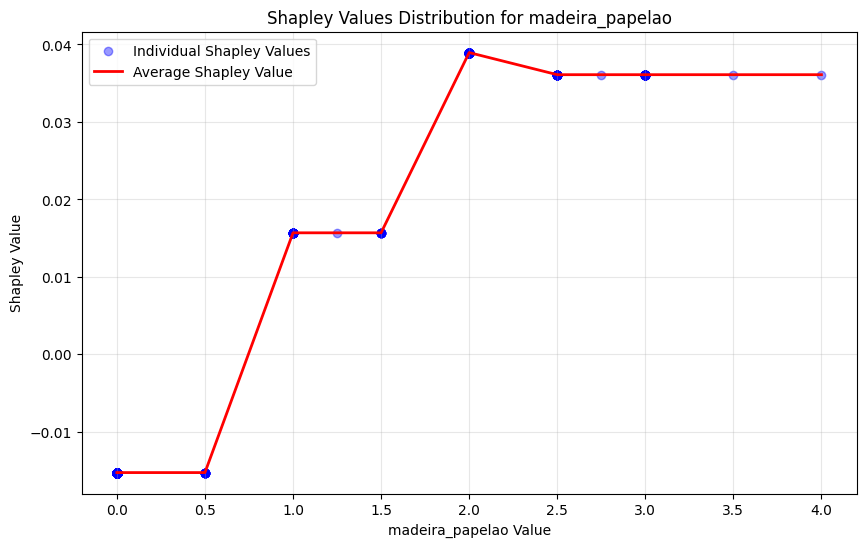

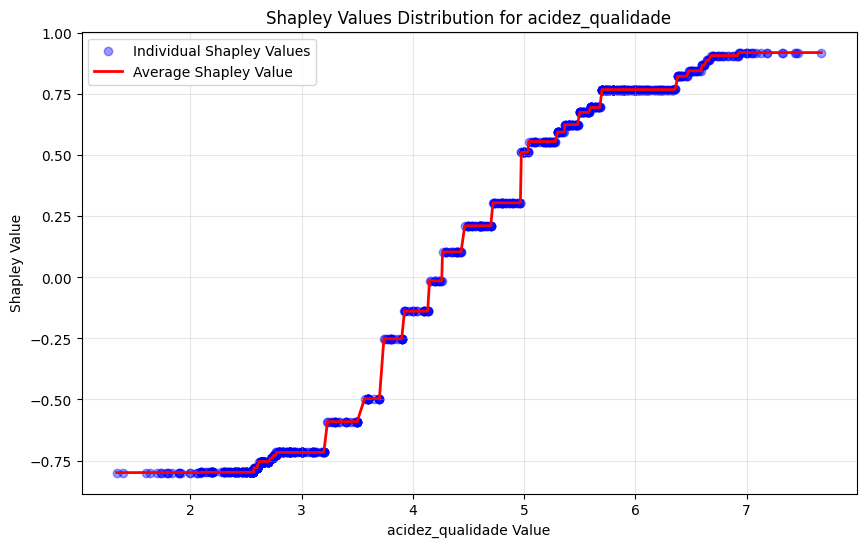

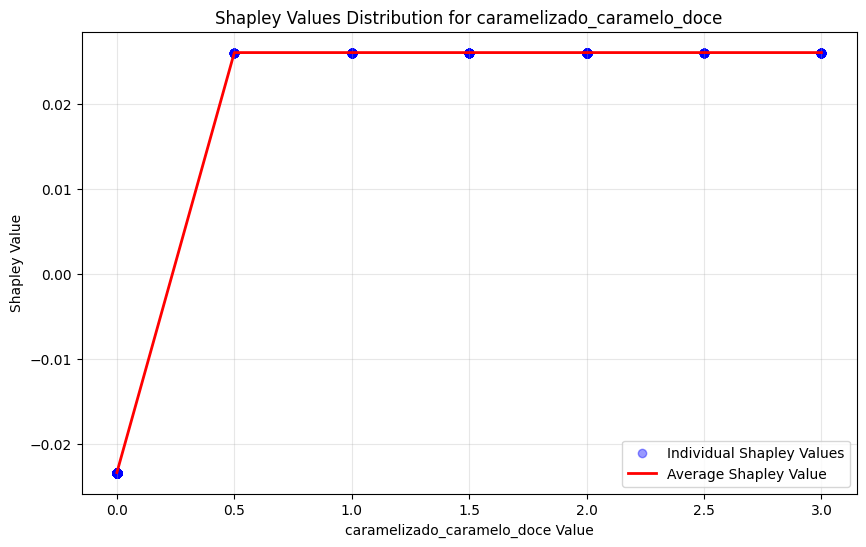

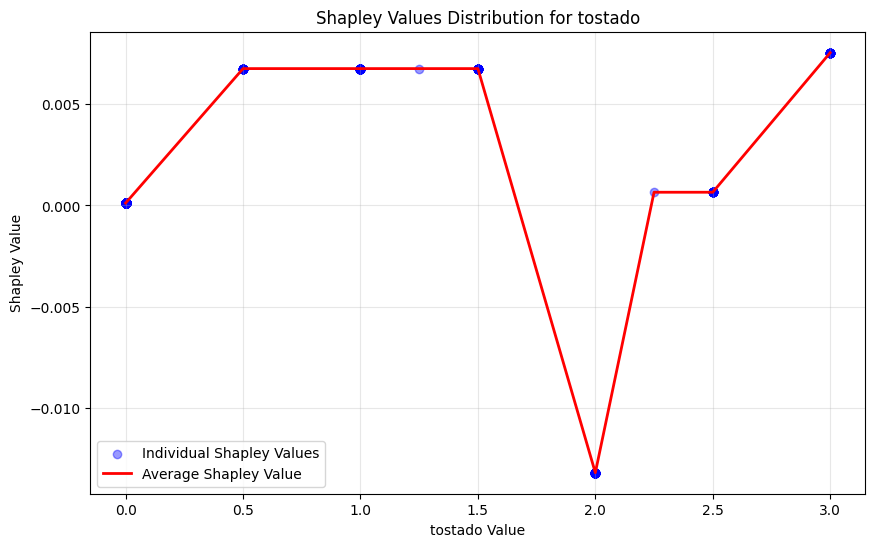

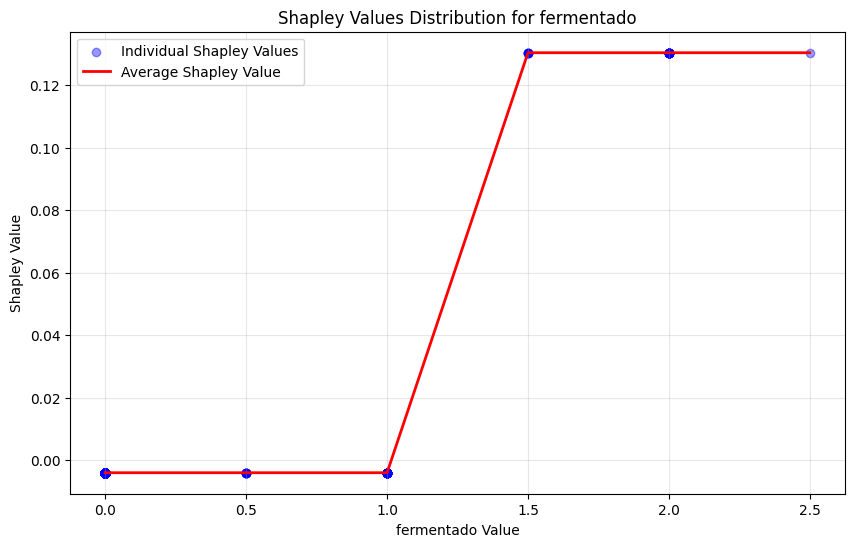

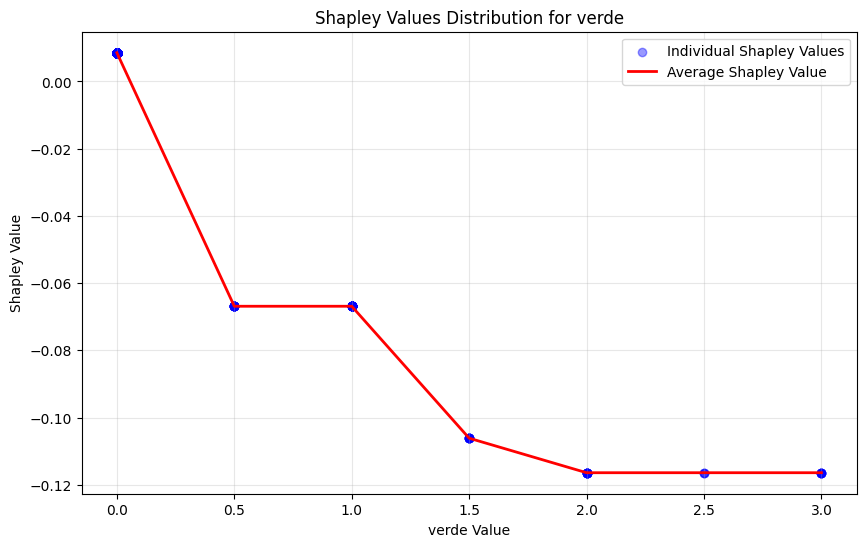

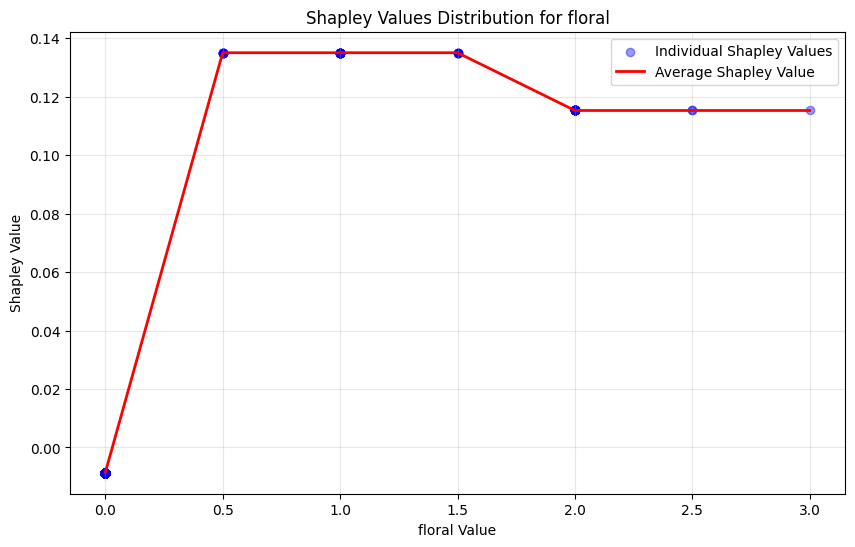

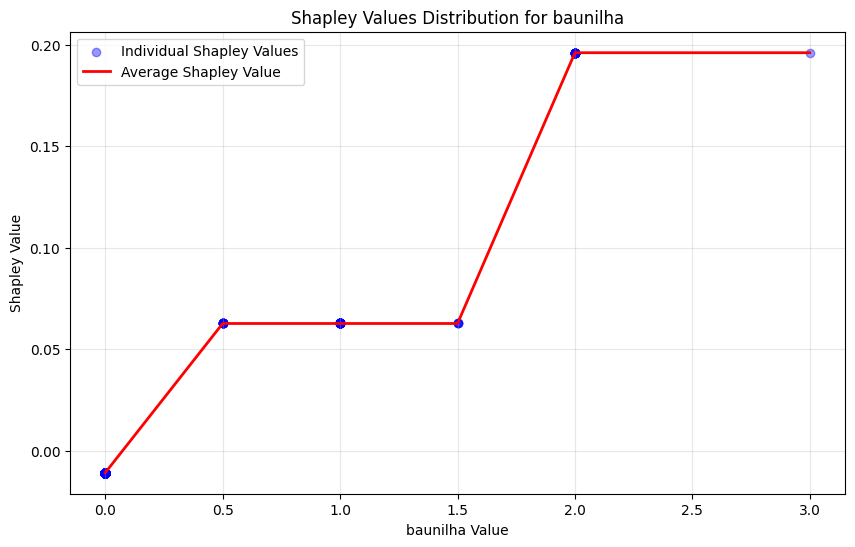

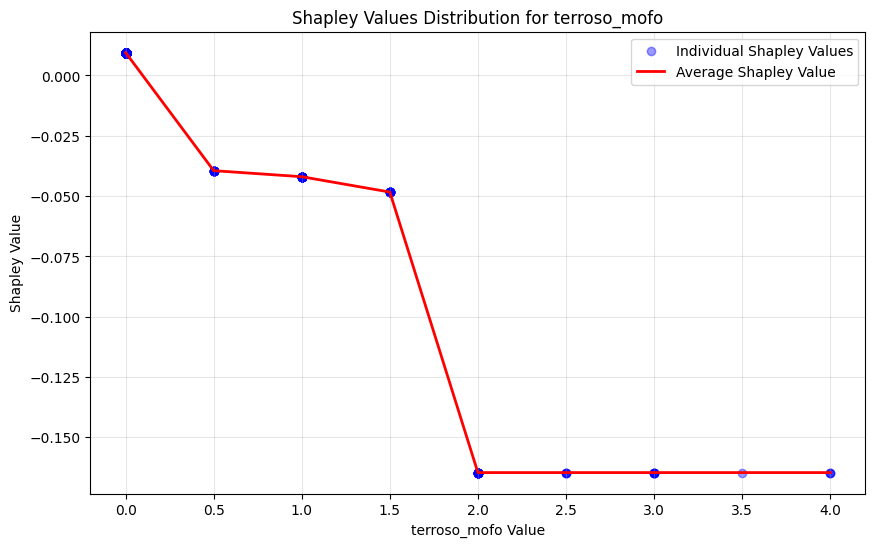

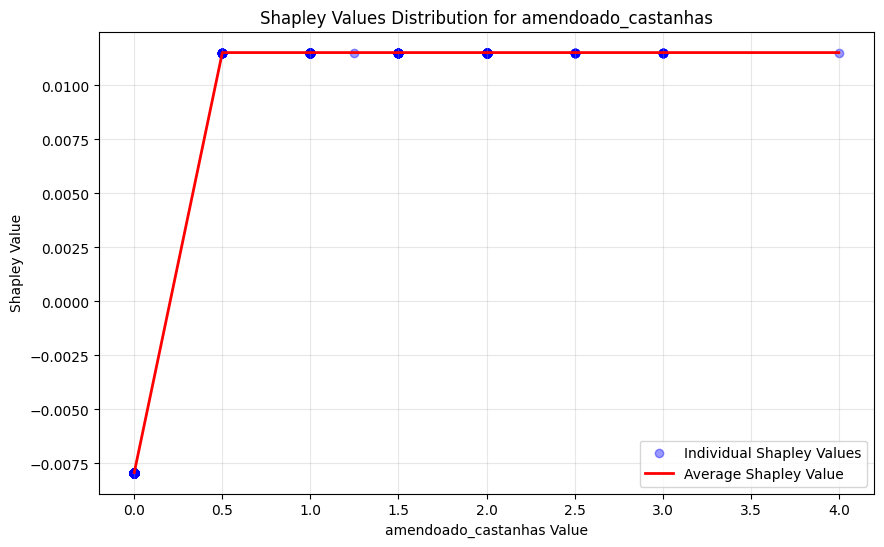

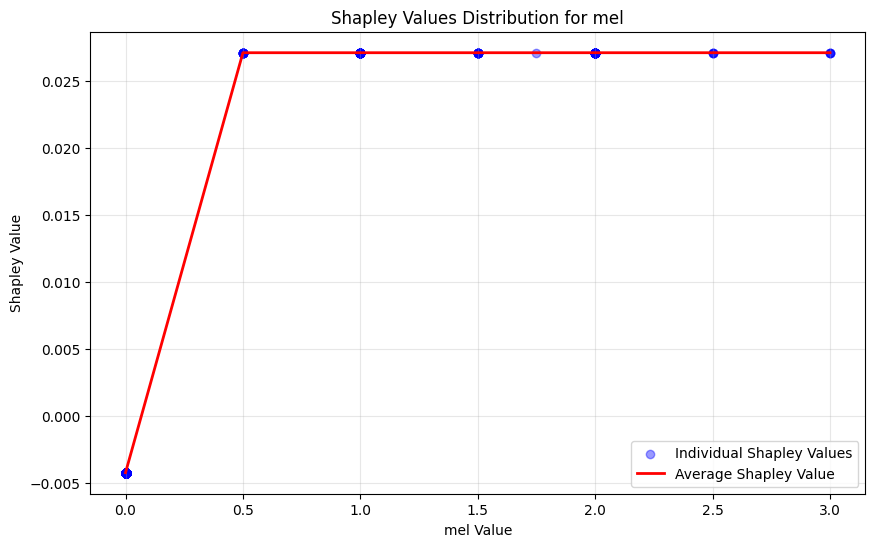

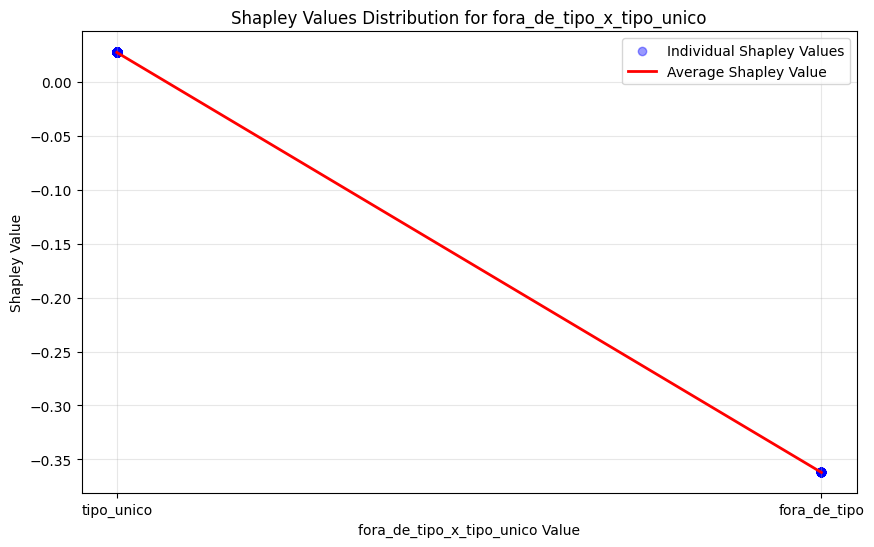

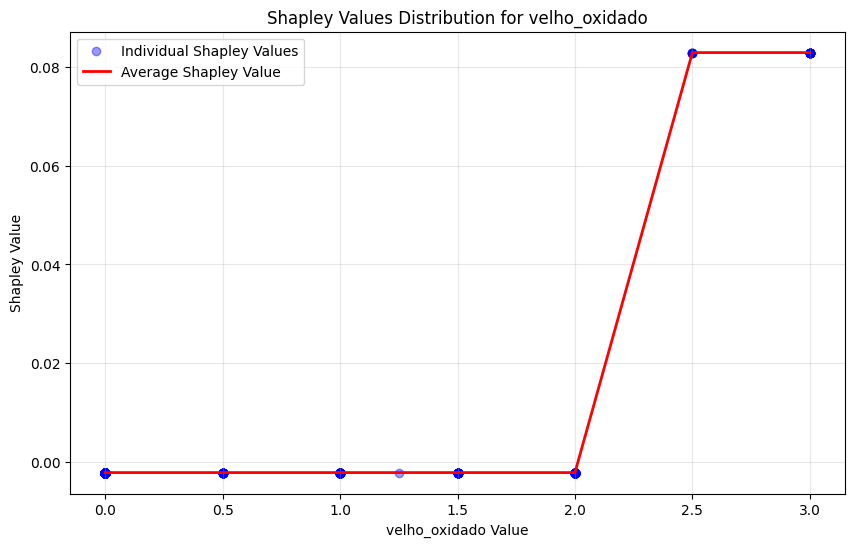

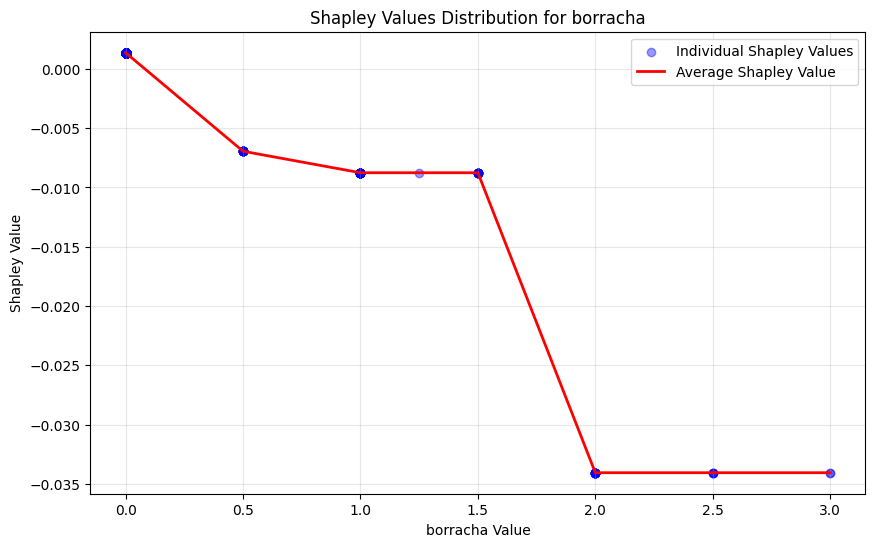

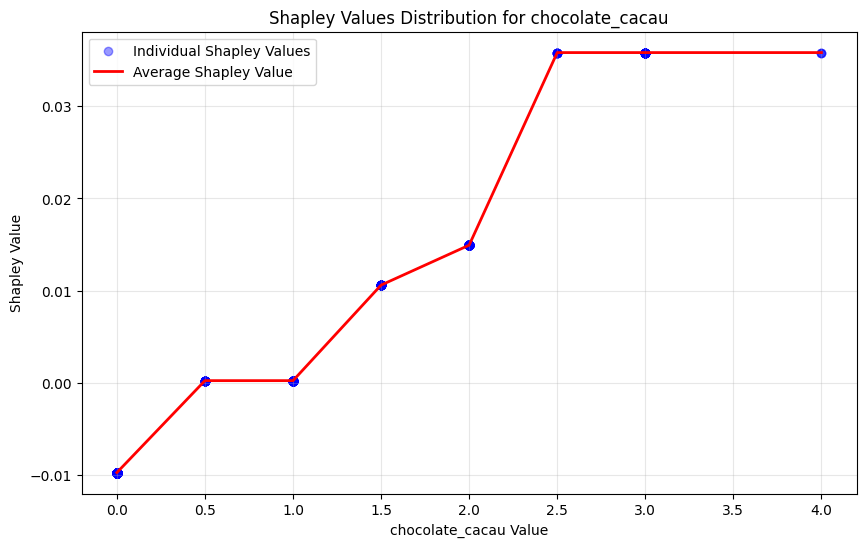

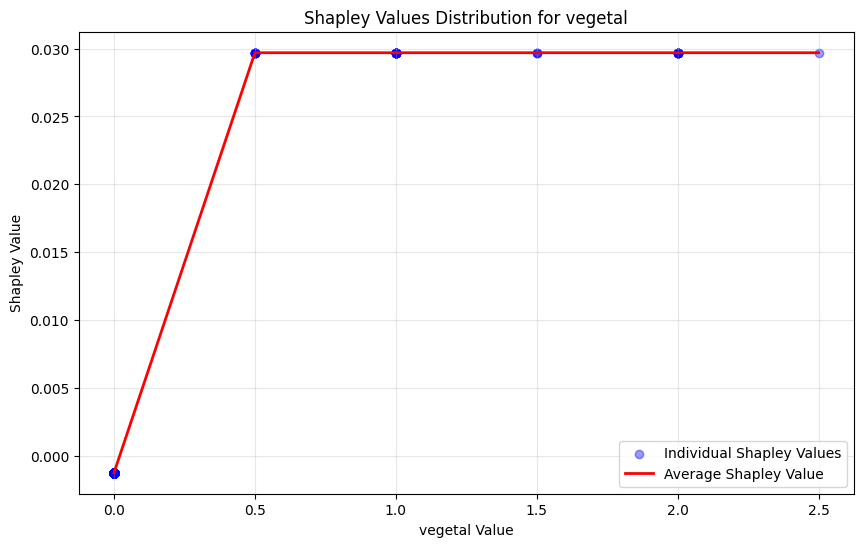

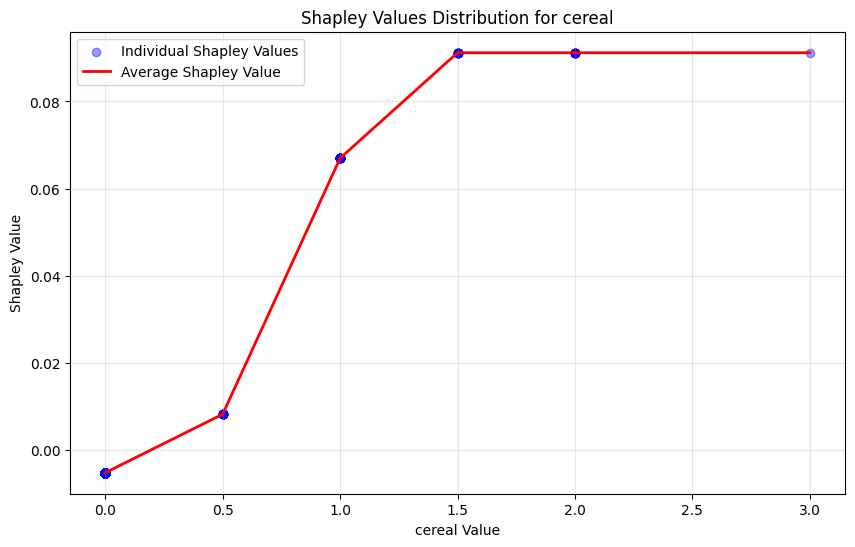

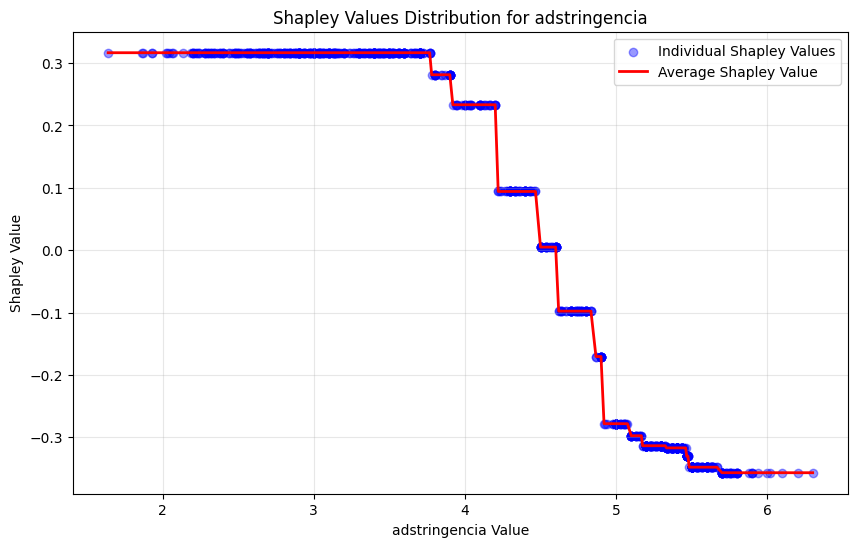

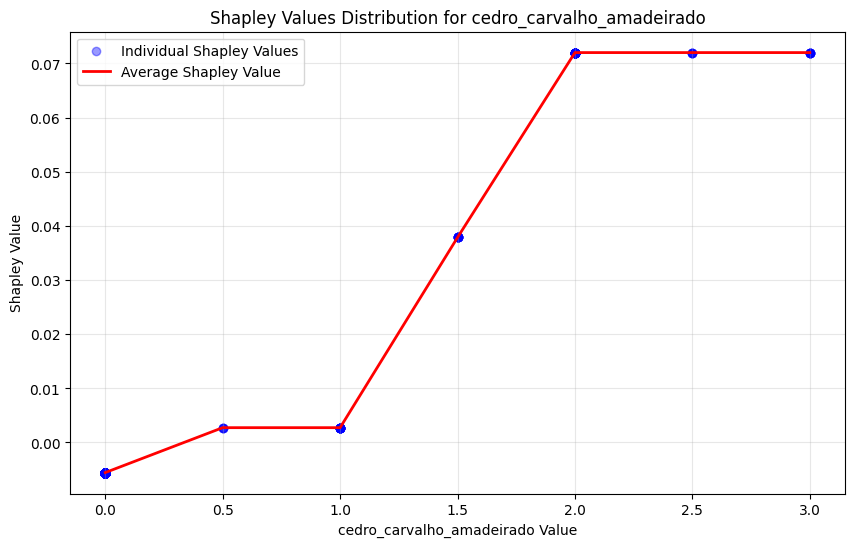

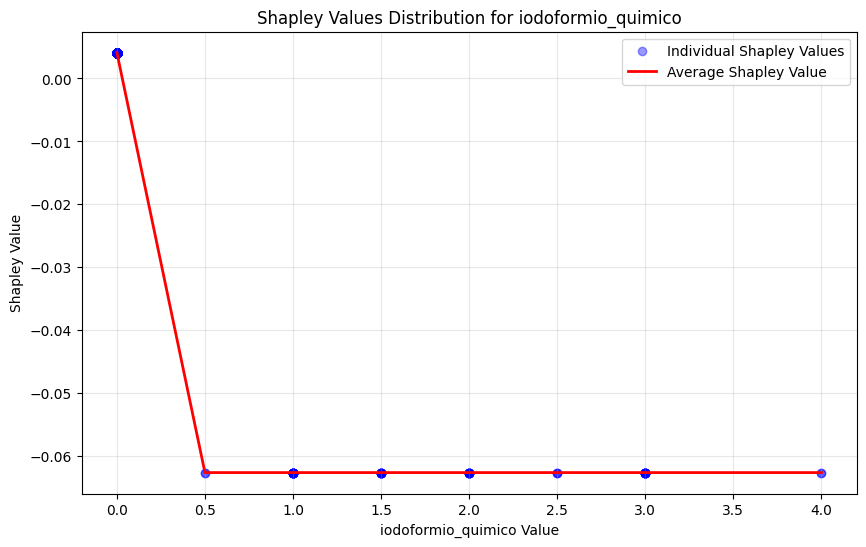

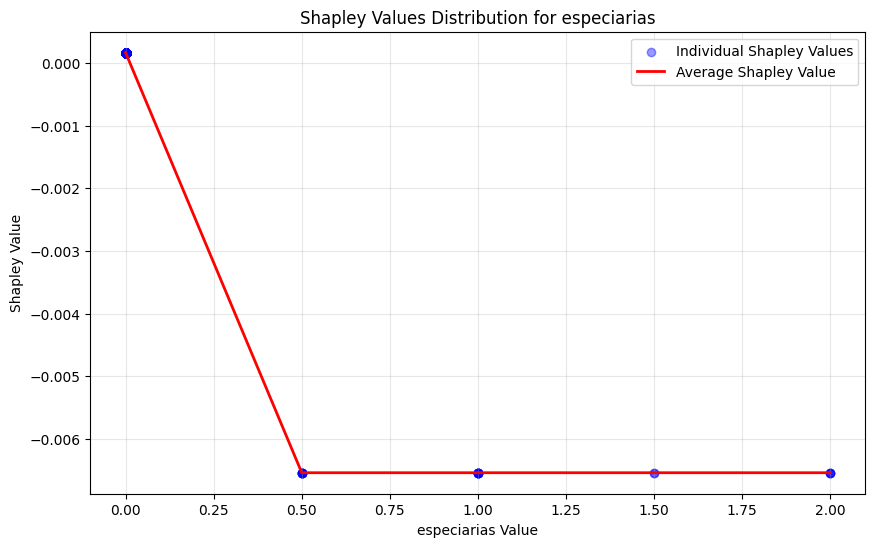

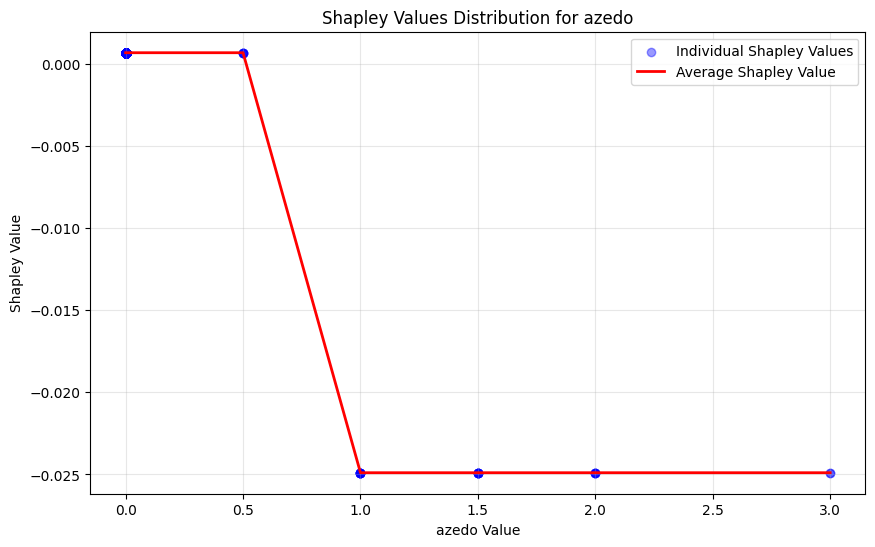

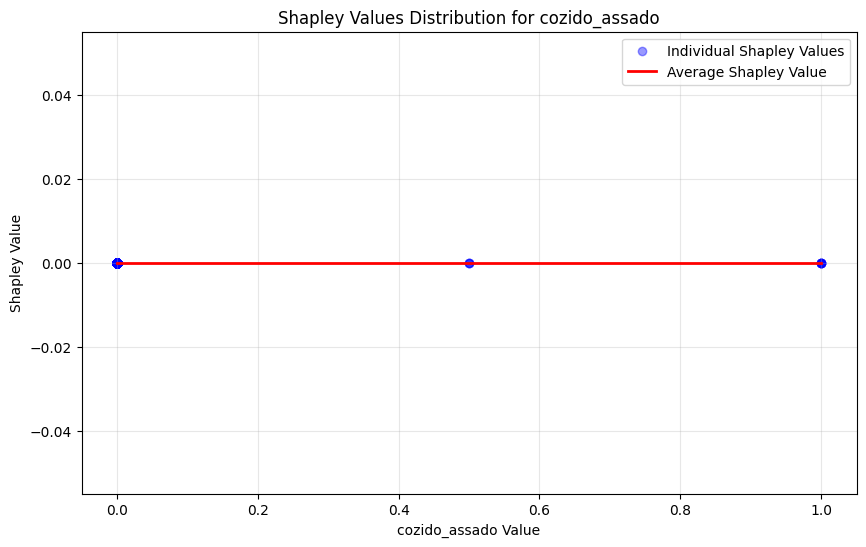

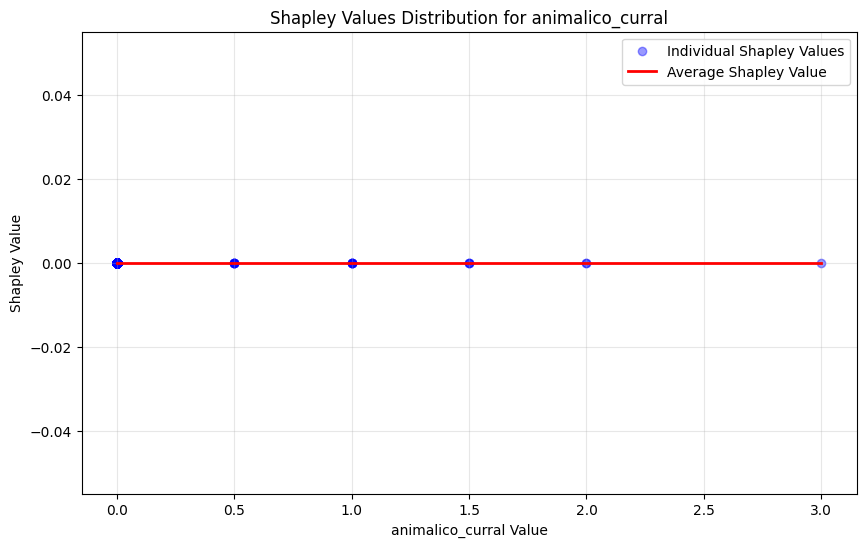

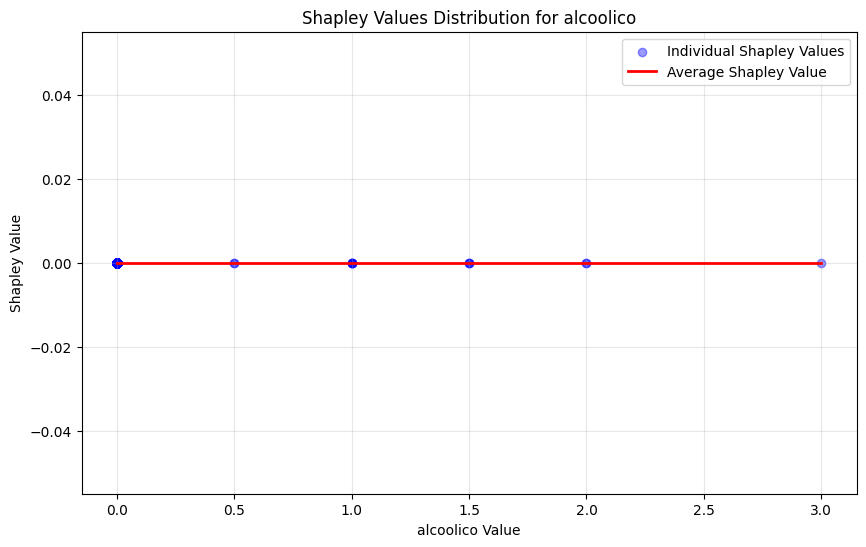

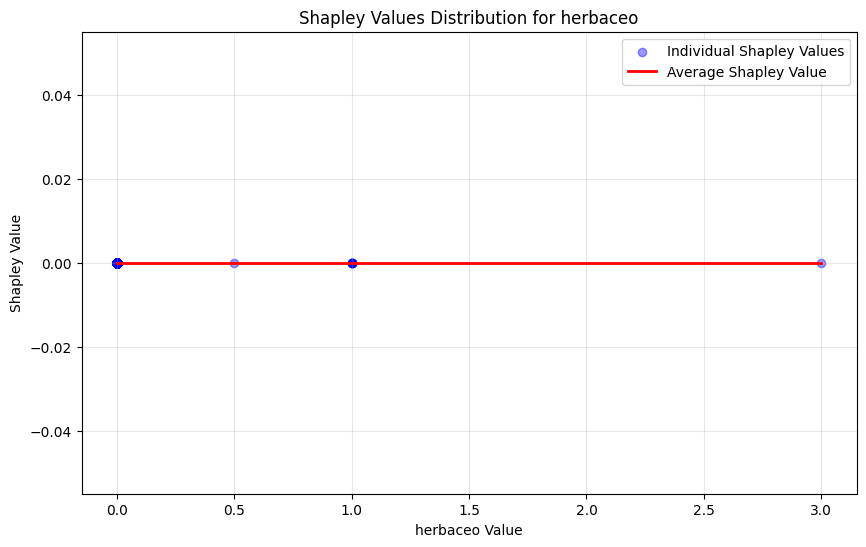

In [31]:
from func import plot_shapley_values

for name in main_imp.index.values:
    plot_shapley_values(shap_df,trn_data ,name)


# <a id='toc7_'></a>[Interaction analysis](#toc0_)

In [32]:
est_data = trn_data.copy()
for cat_var in categorical_features:
    est_data[cat_var] = est_data[cat_var].cat.codes


In [33]:
from shap.utils import approximate_interactions
import shap

exp = TreeExplainer(int_mdl)
shap_interaction_values = exp.shap_interaction_values(est_data)
shap_vals = exp.shap_values(trn_data)


shap_df = pd.DataFrame(shap_vals, columns=trn_data.columns)
int_order = {}

for col in trn_data.columns:
   int_order[col] = approximate_interactions(index=col, shap_values=shap_vals, X=trn_data, feature_names=trn_data.columns)



## <a id='toc7_1_'></a>[Main interactions](#toc0_)

In [34]:
tbl = dict()
for col in int_imp.index.values:

    int_vars = [trn_data.columns[int_order[col][i]] for i in range(3)]
    tbl[col]=int_vars

tbl = pd.DataFrame(tbl).transpose()
tbl.index.name = "Feature"
tbl.columns = ["Top 1 interaction", "Top 2 interaction", "Top 3 interaction"]
tbl

Top 1 interaction   Top 2 interaction  \
Feature                                                                     
odor_do_po                         acidez_intensidade              docura   
intensidade                                   amargor              docura   
amargor                                         corpo              docura   
corpo                                     intensidade         laboratorio   
acidez_intensidade                        intensidade         laboratorio   
adstringencia                             laboratorio          odor_do_po   
docura                      cedro_carvalho_amadeirado             tostado   
acidez_qualidade                          laboratorio         intensidade   
queimado_defumado                       velho_oxidado             amargor   
velho_oxidado                         madeira_papelao       adstringencia   
chocolate_cacau                               frutado             amargor   
tostado                                   laboratorio       adstringencia   
madeira_papelao                    acidez_intensidade          odor_do_po   
laboratorio                               intensidade    acidez_qualidade   
caramelizado_caramelo_doce                 odor_do_po     chocolate_cacau   
frutado                               chocolate_cacau              docura   
fora_de_tipo_x_tipo_unico                terroso_mofo   queimado_defumado   
amendoado_castanhas                     adstringencia         intensidade   
terroso_mofo                        queimado_defumado         laboratorio   
verde                               queimado_defumado              docura   
borracha                                  intensidade       velho_oxidado   
fermentado                           acidez_qualidade       adstringencia   
mel                                           frutado         intensidade   
cedro_carvalho_amadeirado             chocolate_cacau         intensidade   
cereal                                     odor_do_po         intensidade   
baunilha                                      frutado              docura   
floral                            amendoado_castanhas               corpo   
iodoformio_quimico                    madeira_papelao  acidez_intensidade   
especiarias                                    cereal     madeira_papelao   
vegetal                                        docura    acidez_qualidade   
azedo                                         amargor              docura   
animalico_curral                          laboratorio     chocolate_cacau   
cozido_assado                             laboratorio     chocolate_cacau   
alcoolico                                 laboratorio     chocolate_cacau   
herbaceo                                  laboratorio     chocolate_cacau   

                                    Top 3 interaction  
Feature                                                
odor_do_po                           acidez_qualidade  
intensidade                        acidez_intensidade  
amargor                              acidez_qualidade  
corpo                                         amargor  
acidez_intensidade                             docura  
adstringencia                             intensidade  
docura                                        amargor  
acidez_qualidade            cedro_carvalho_amadeirado  
queimado_defumado                               corpo  
velho_oxidado                              odor_do_po  
chocolate_cacau                      acidez_qualidade  
tostado                                    odor_do_po  
madeira_papelao                               amargor  
laboratorio                                    docura  
caramelizado_caramelo_doce                    tostado  
frutado                                   intensidade  
fora_de_tipo_x_tipo_unico            acidez_qualidade  
amendoado_castanhas                           amargor  
terroso_mofo                                   docura  
verde     

## <a id='toc7_2_'></a>[Interaction plots](#toc0_)

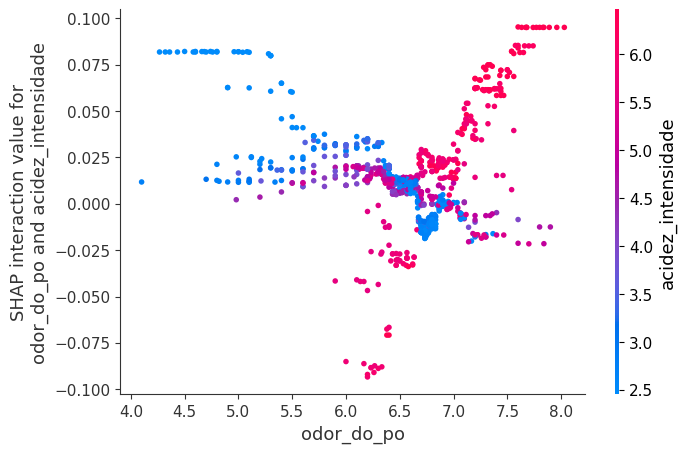

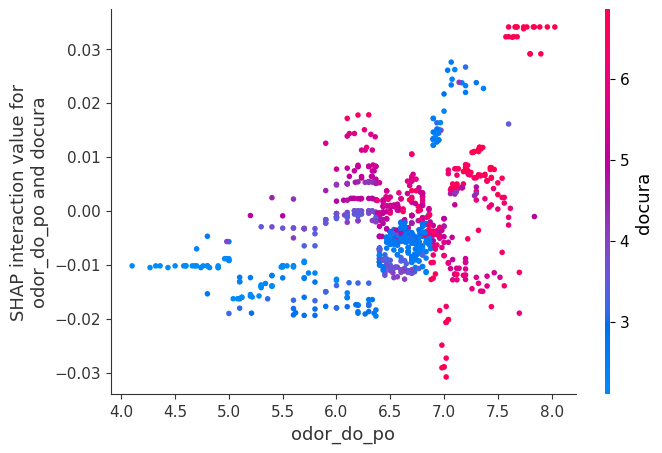

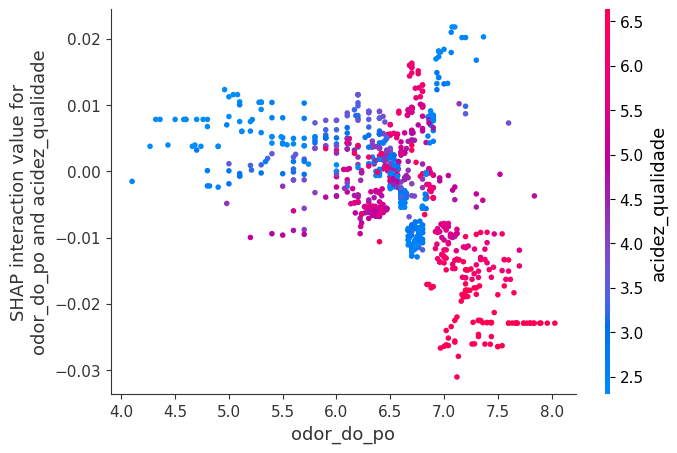

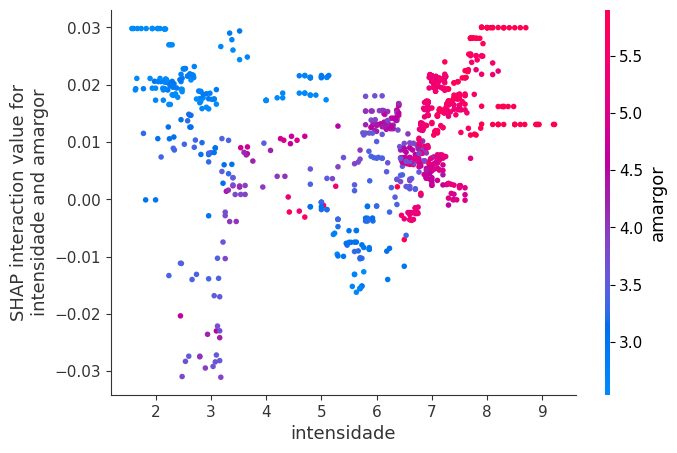

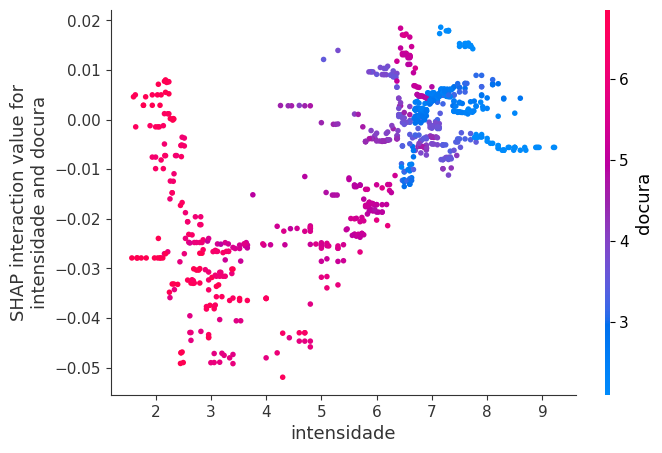

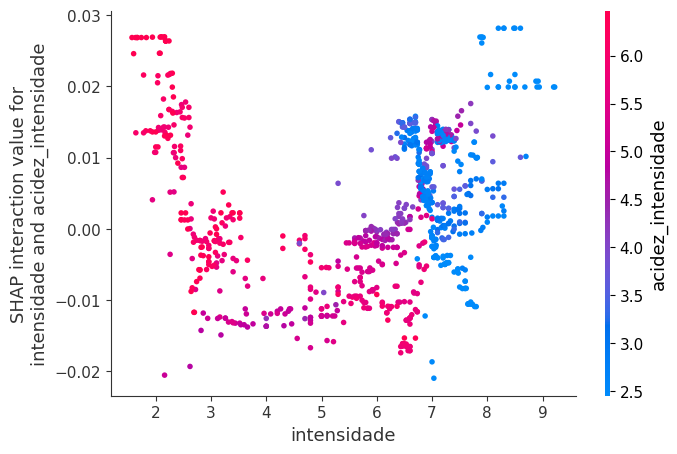

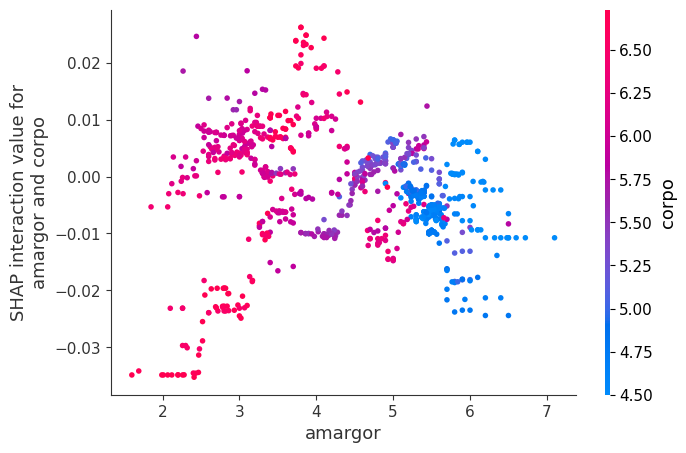

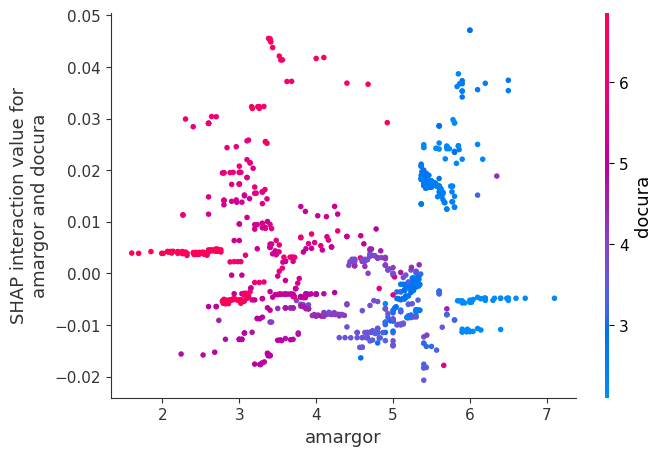

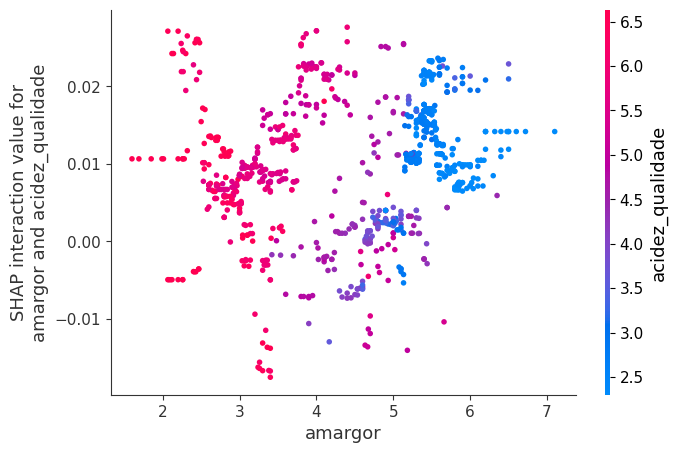

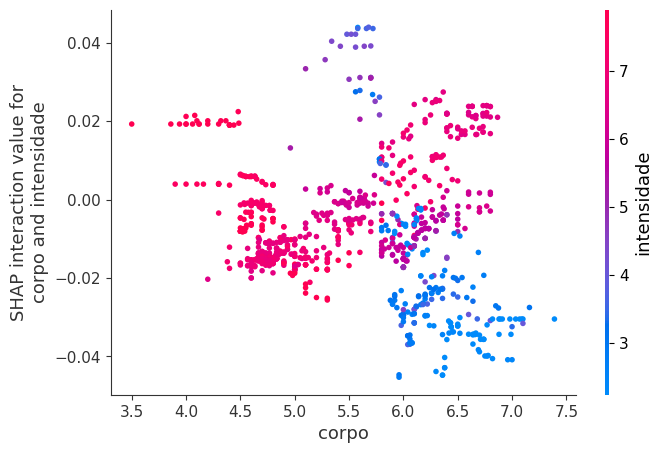

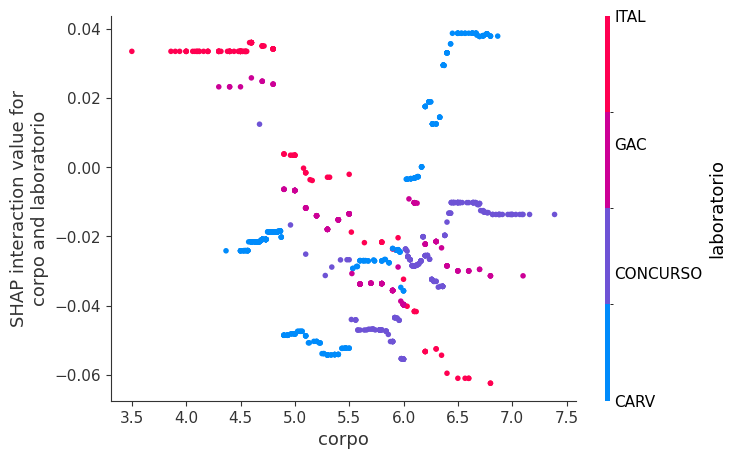

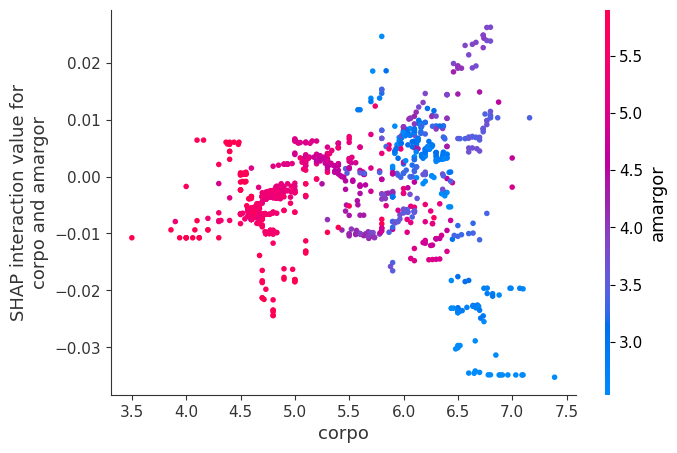

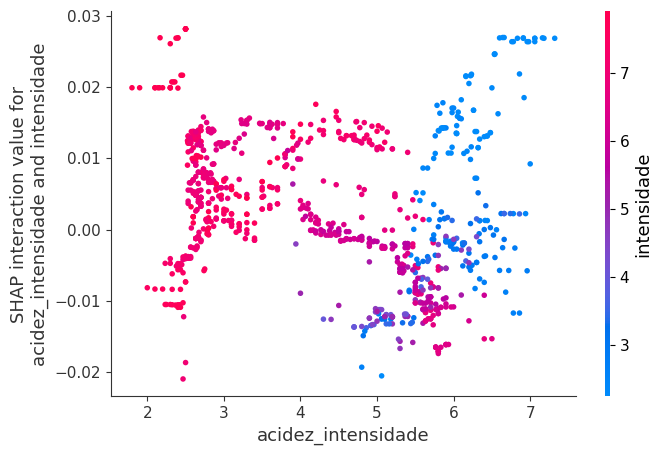

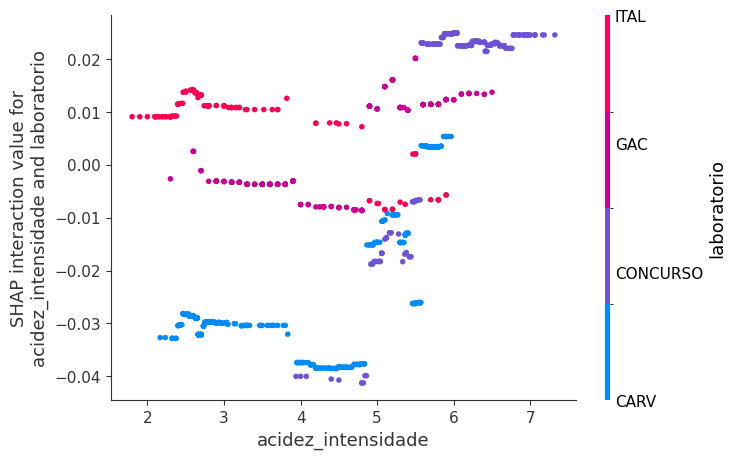

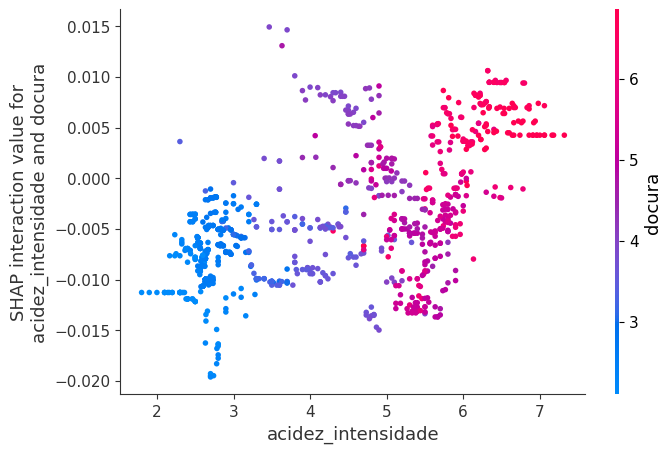

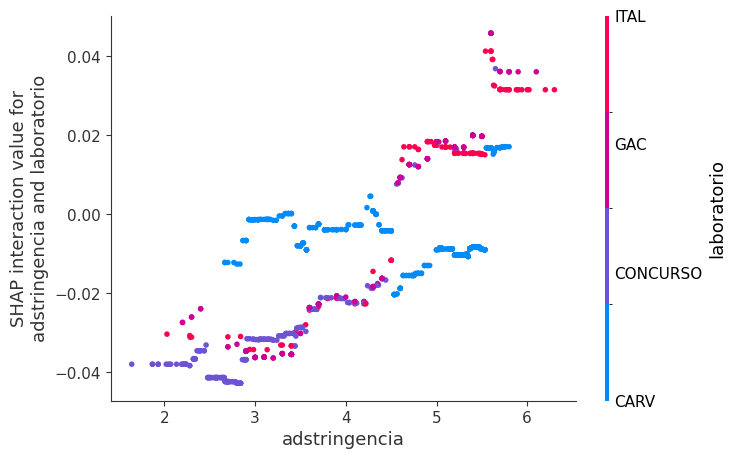

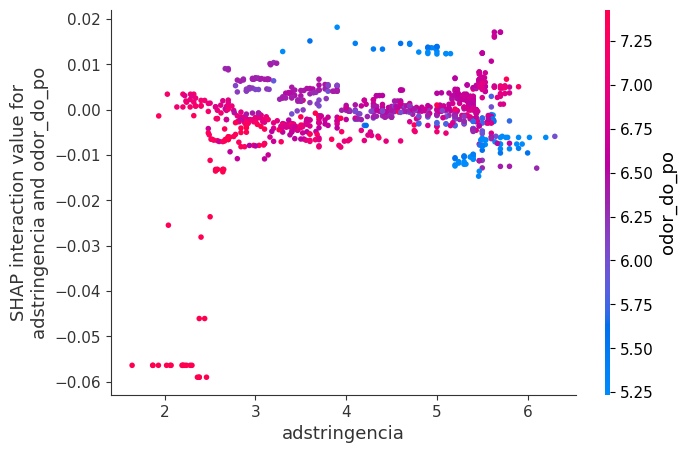

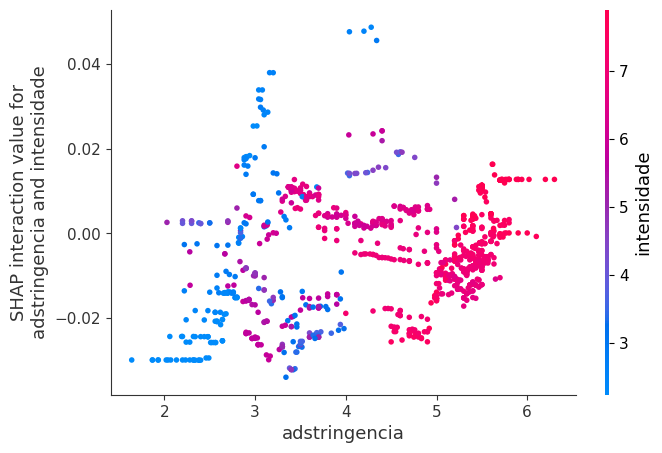

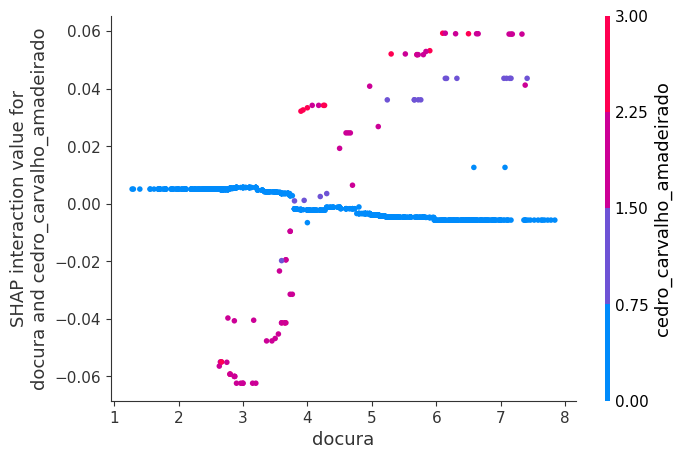

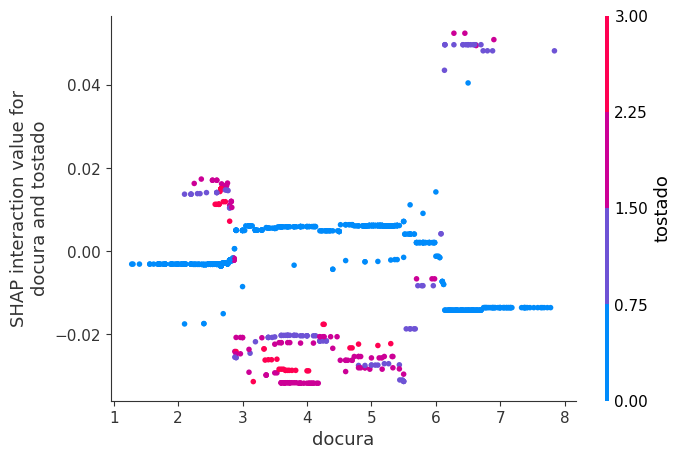

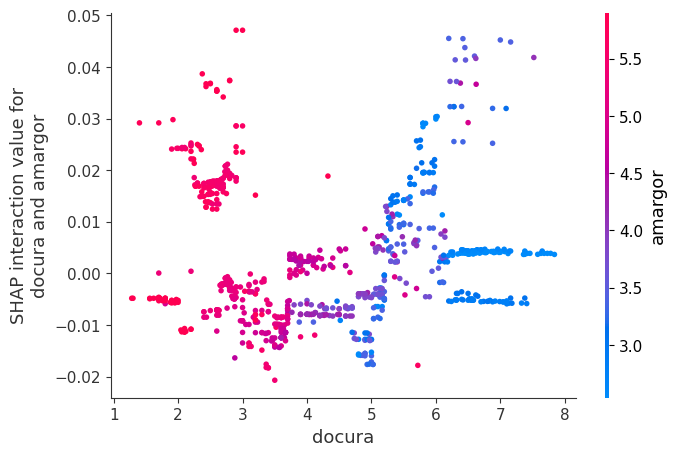

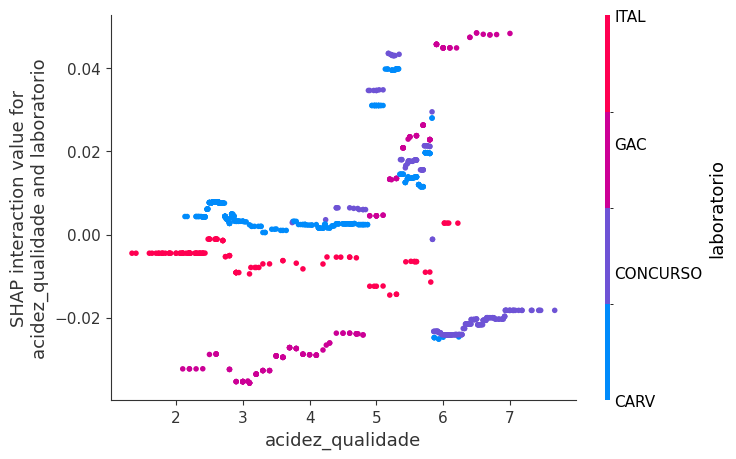

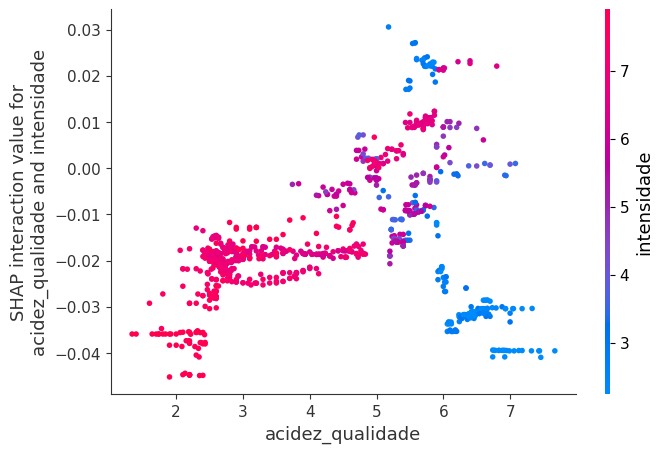

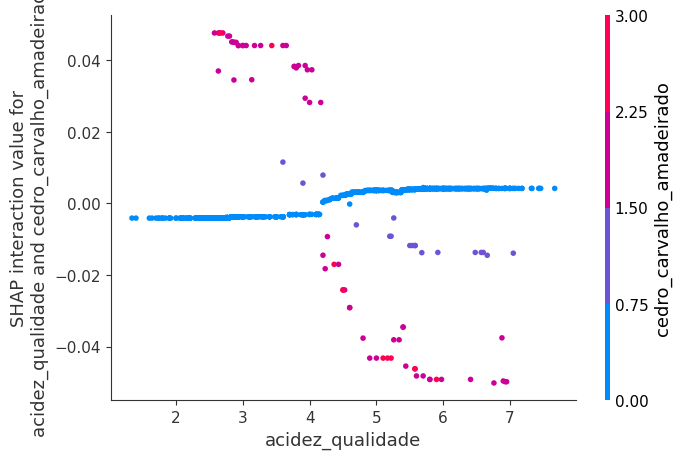

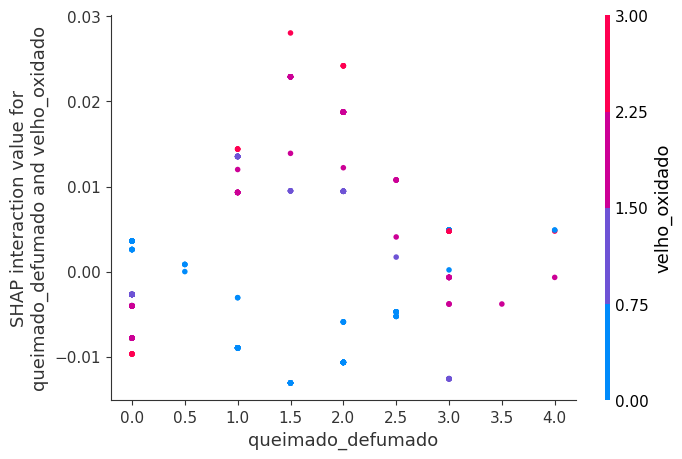

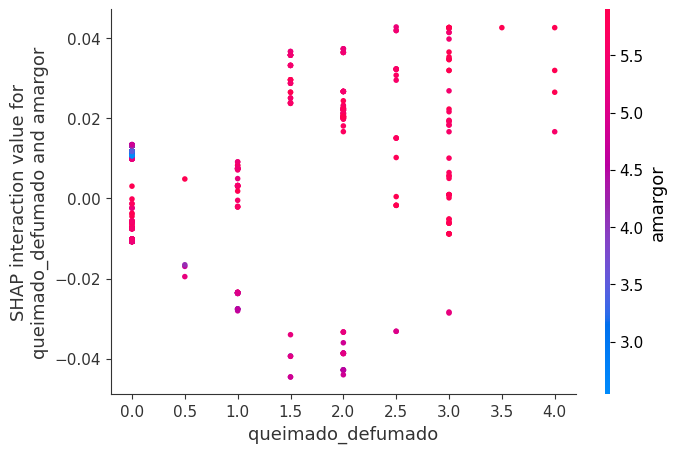

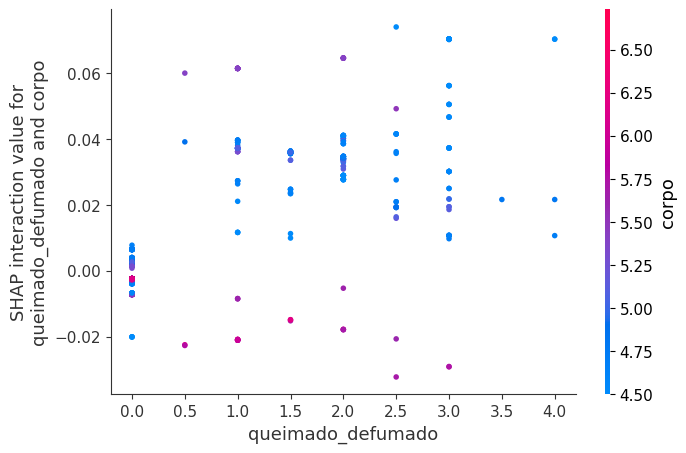

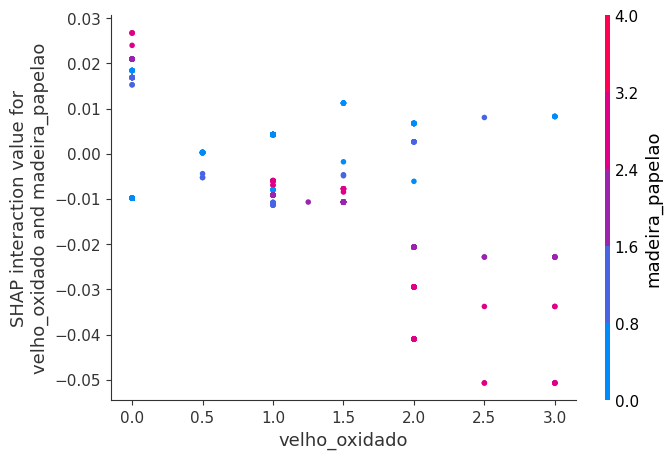

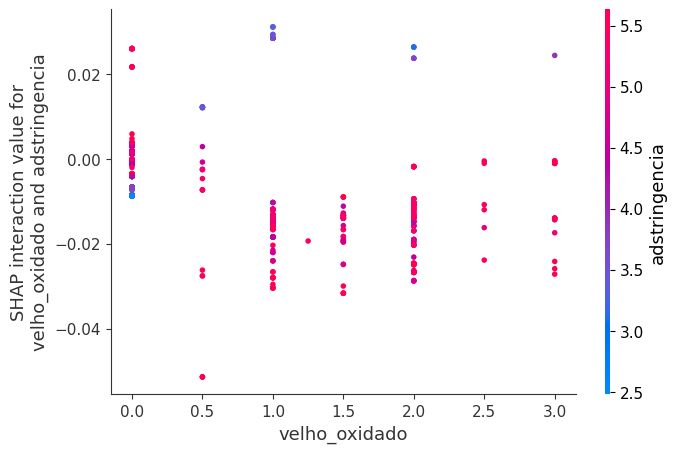

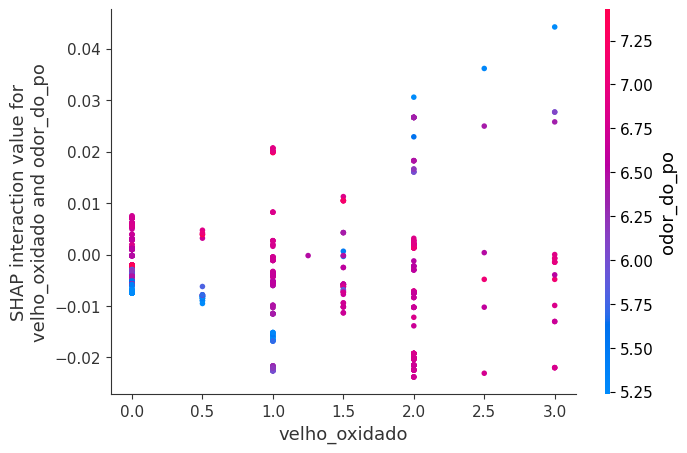

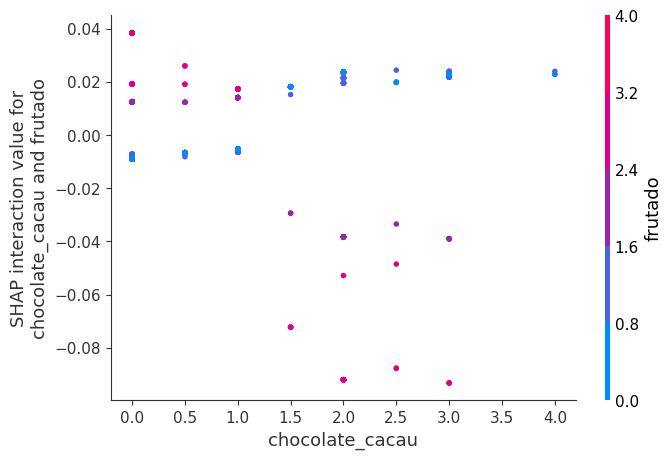

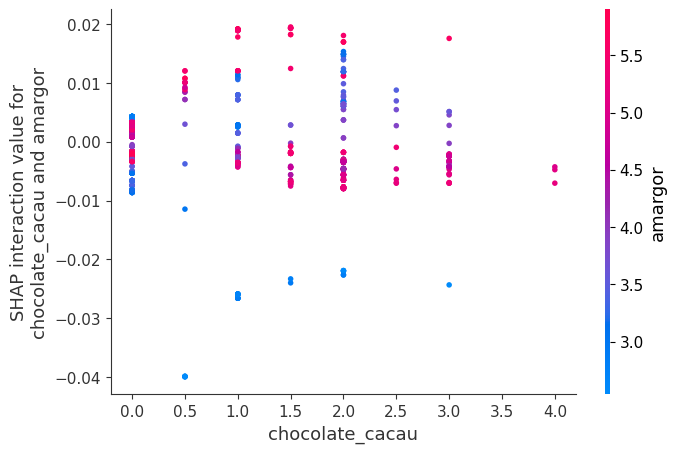

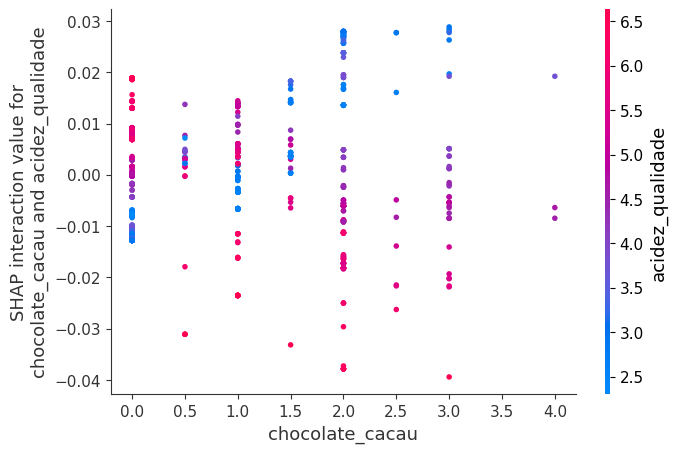

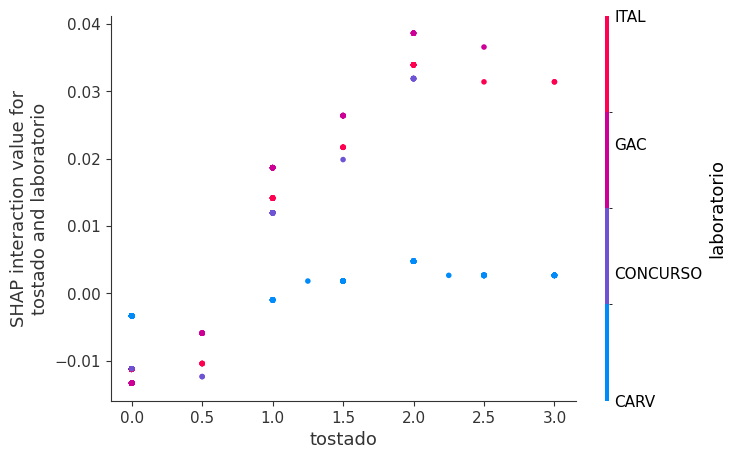

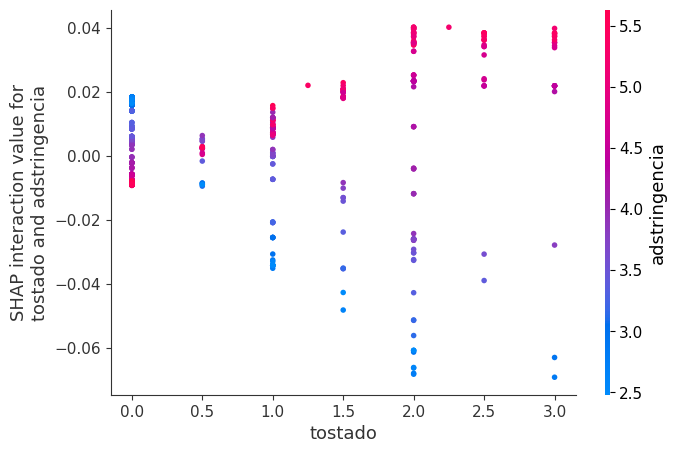

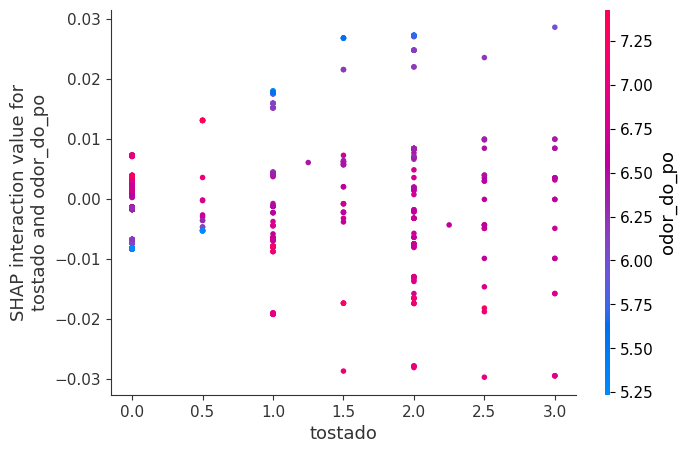

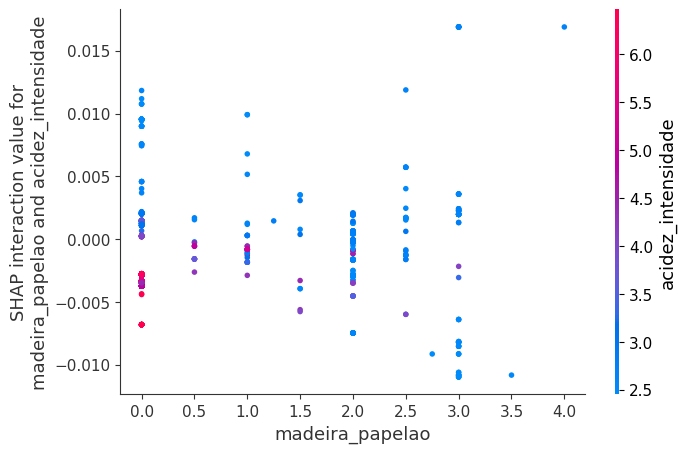

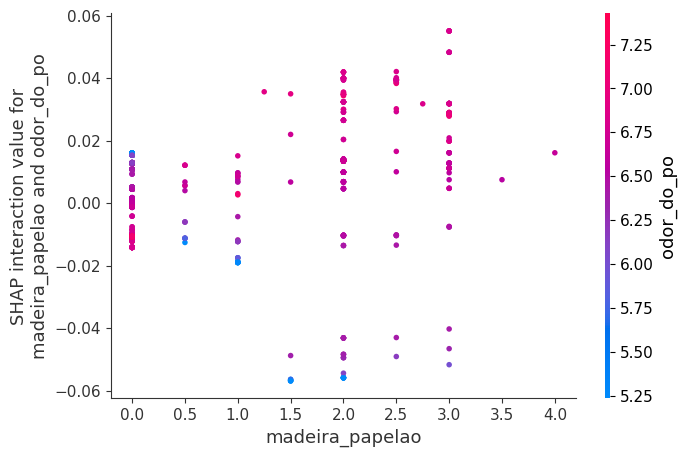

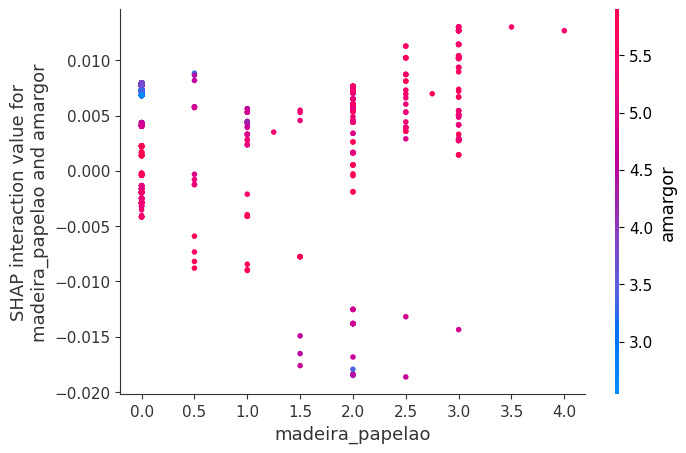

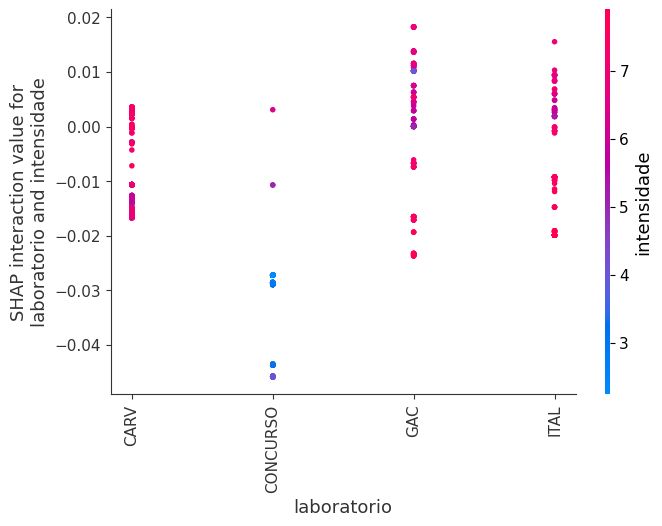

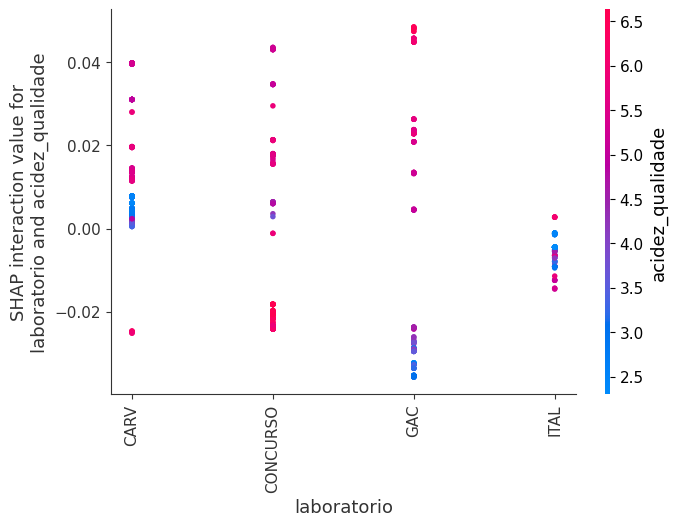

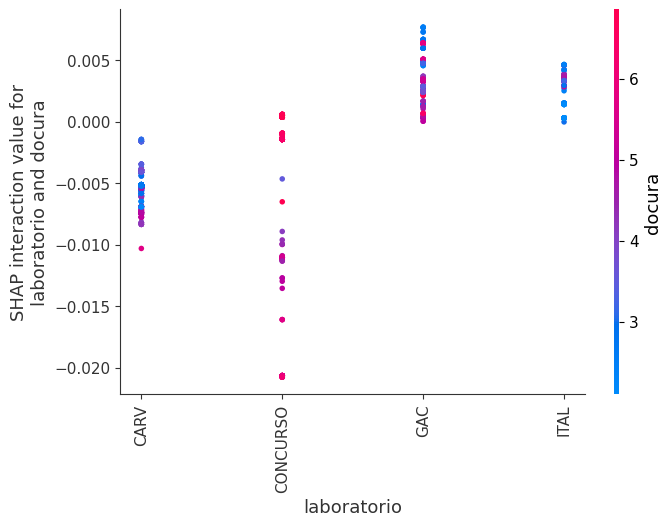

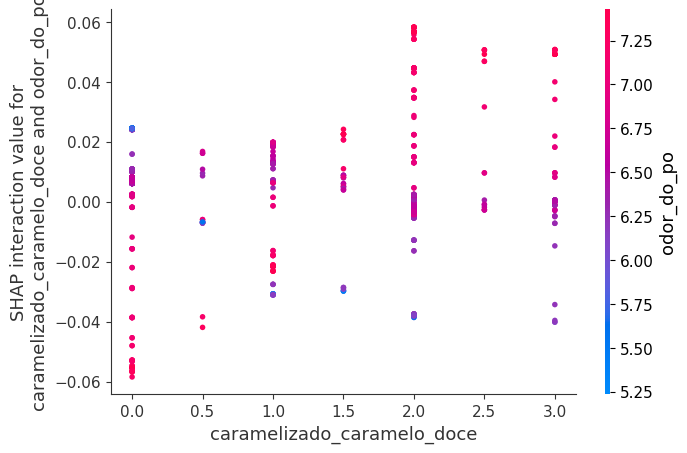

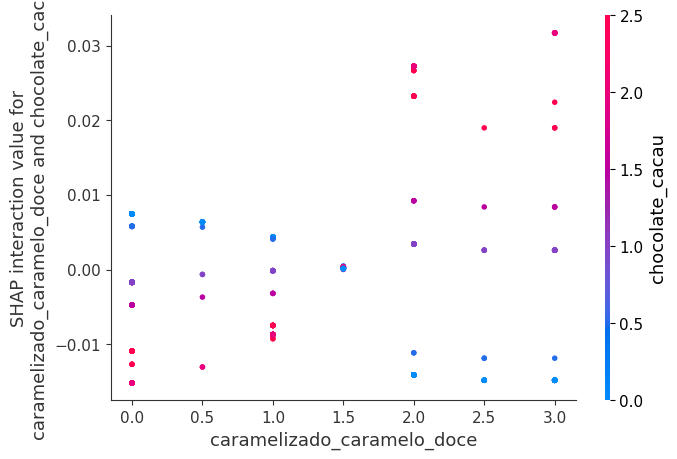

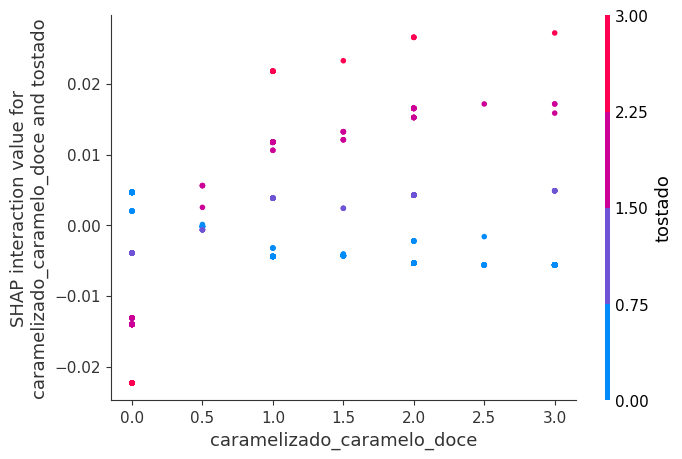

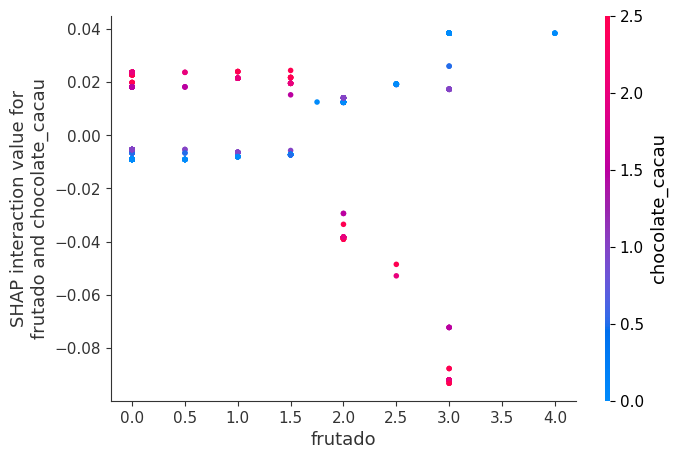

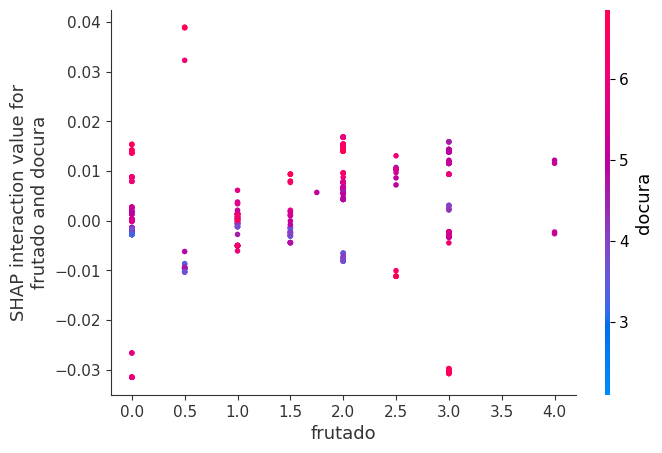

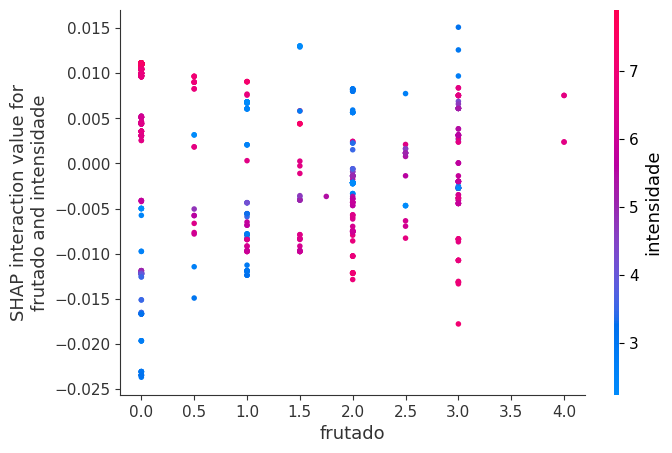

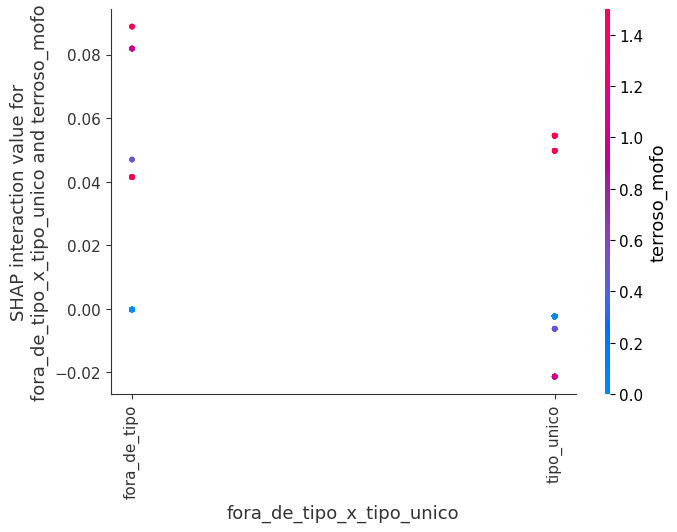

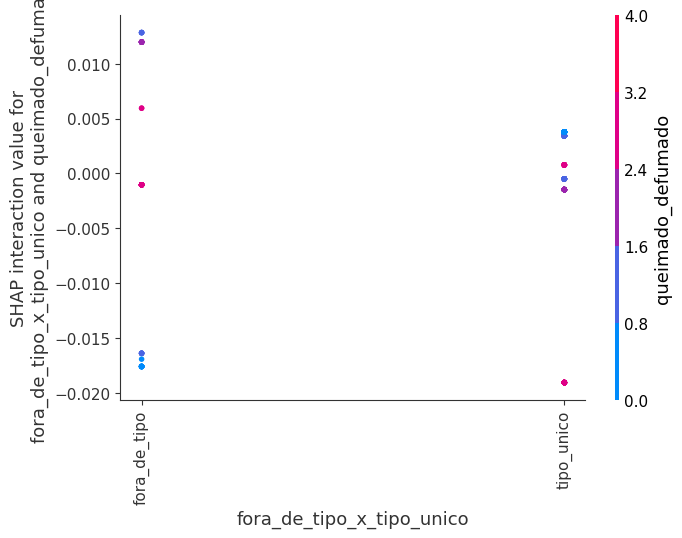

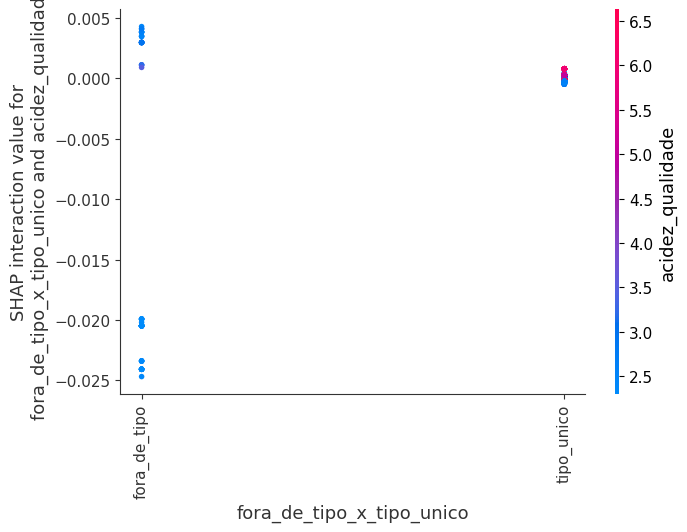

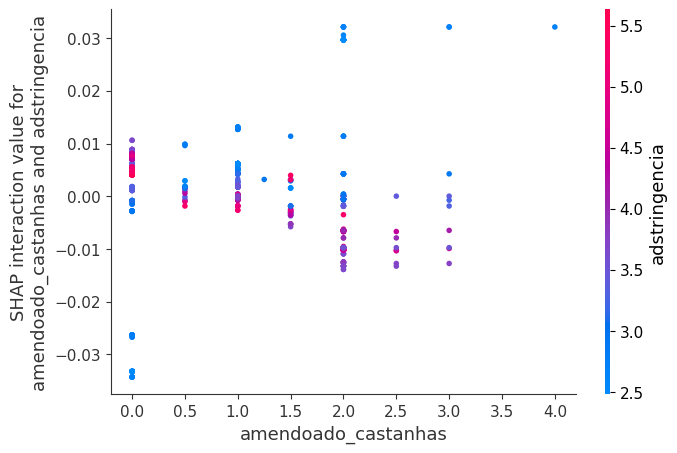

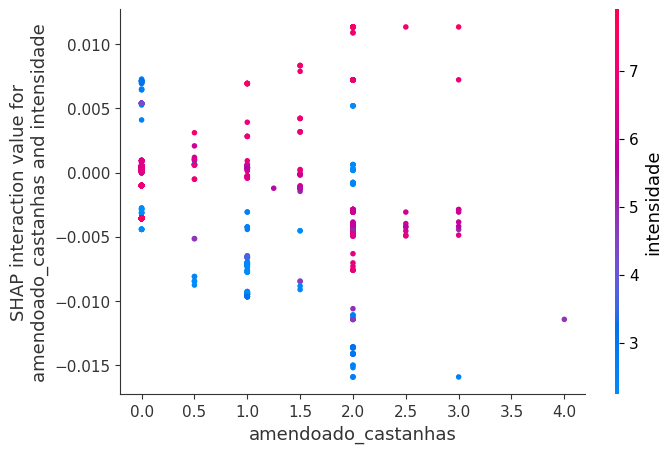

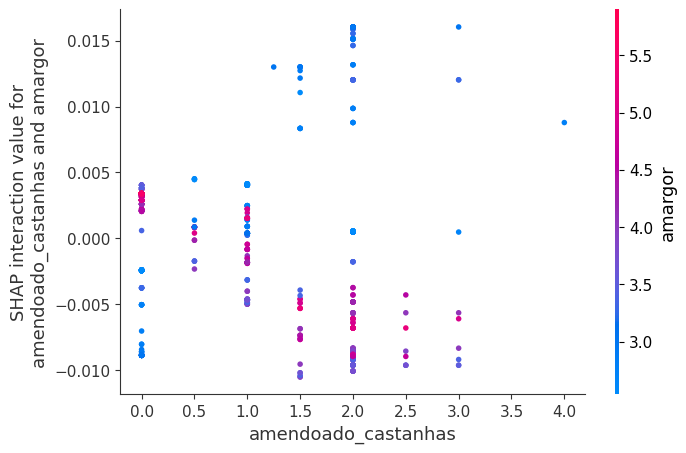

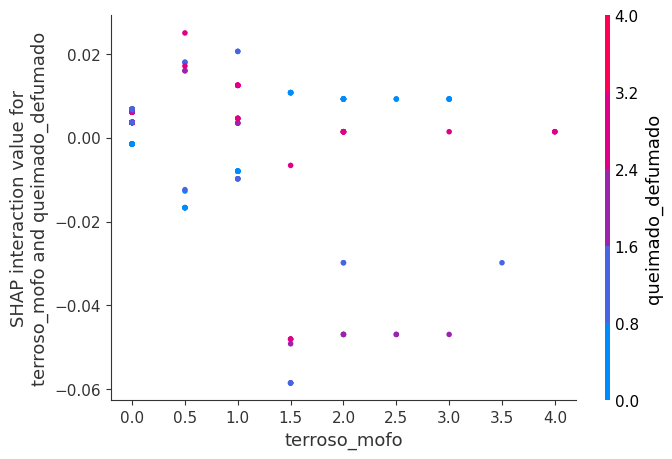

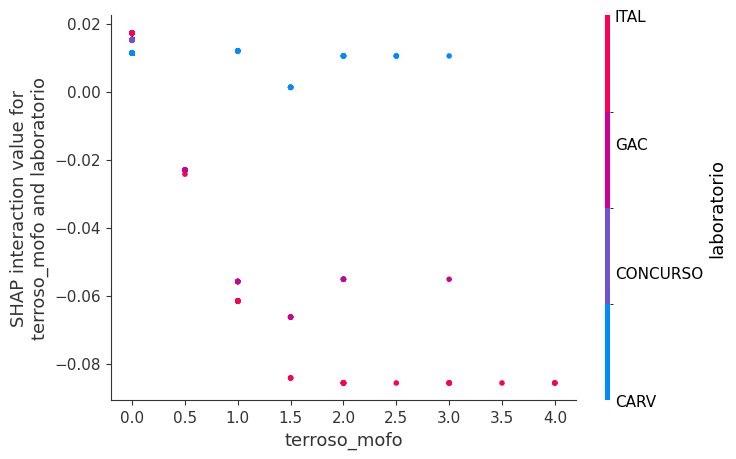

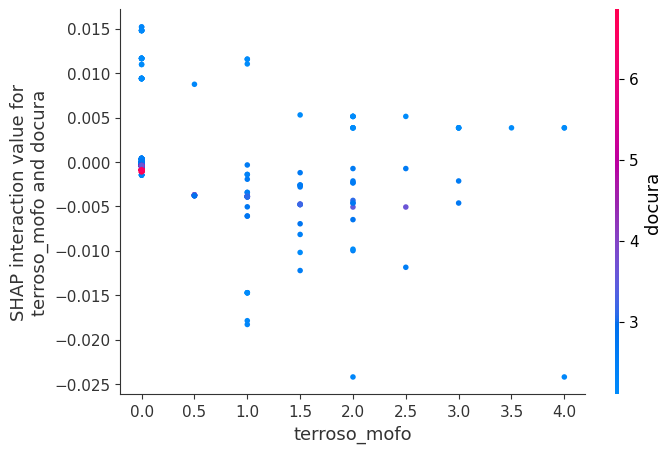

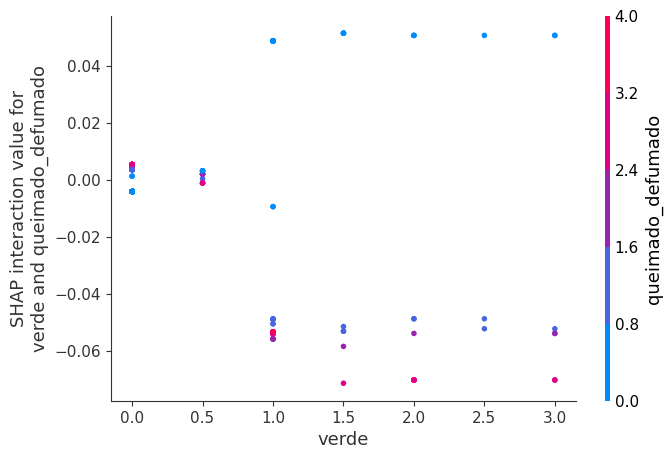

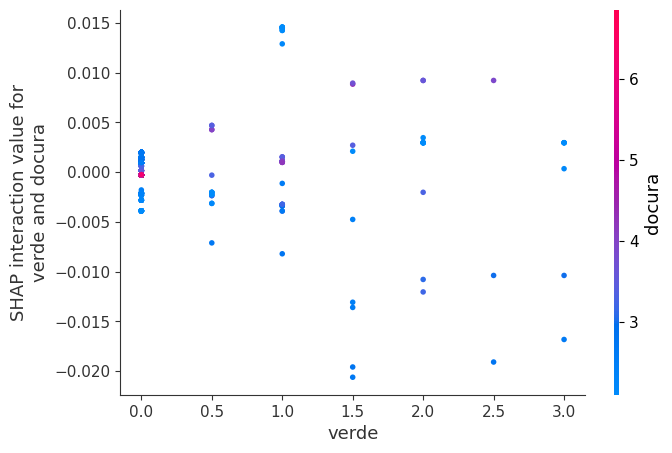

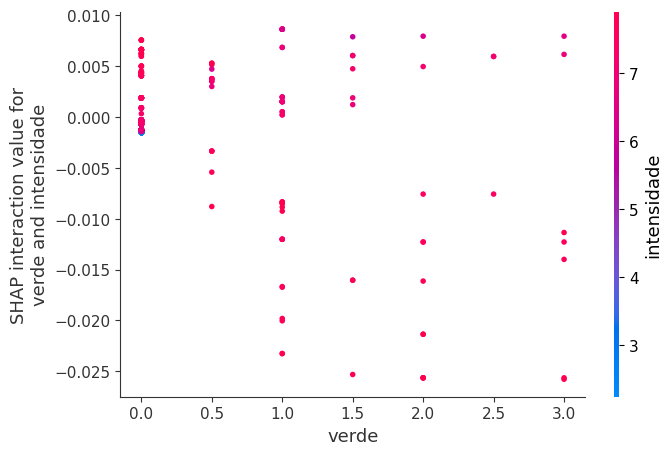

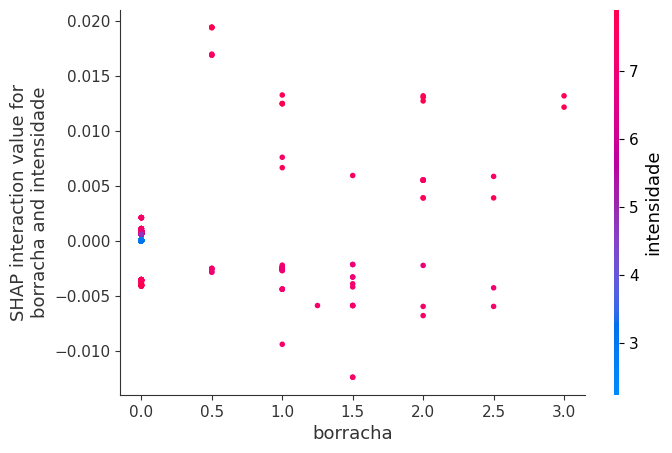

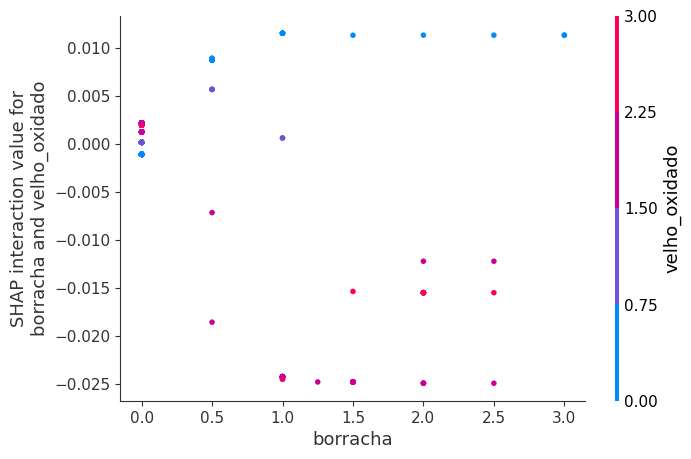

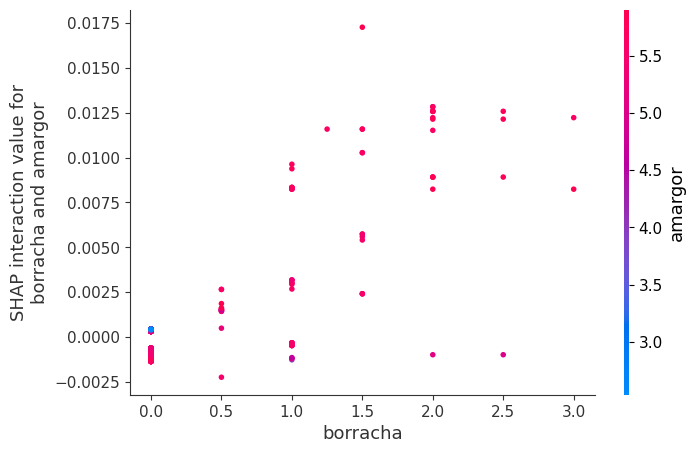

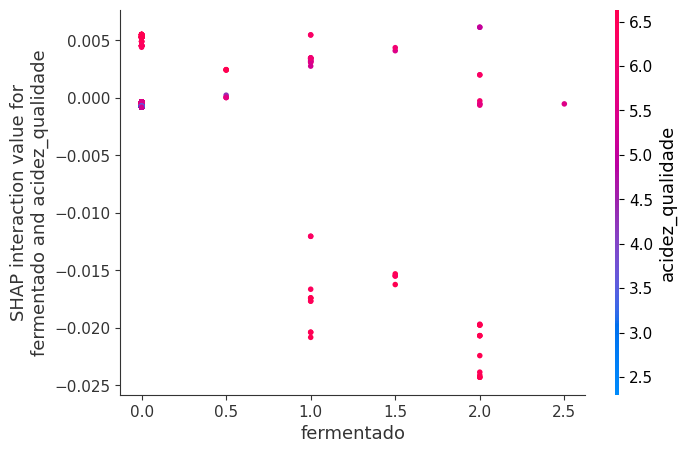

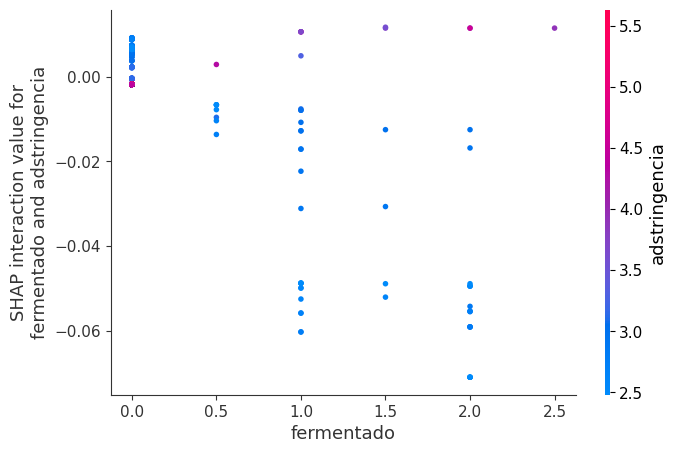

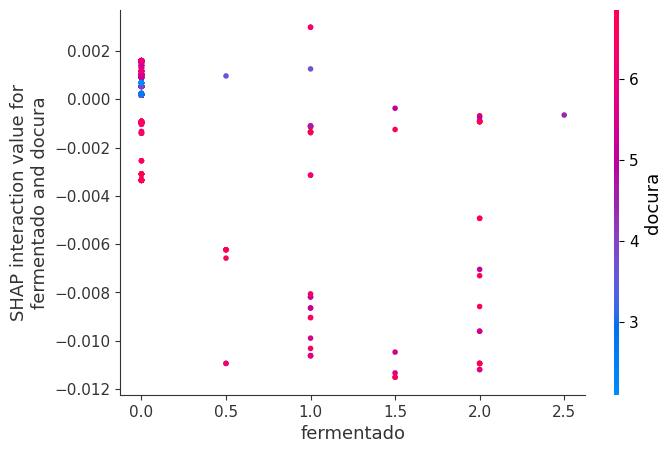

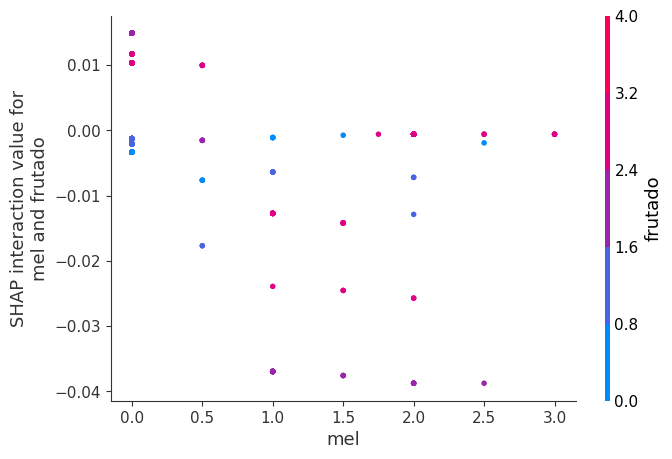

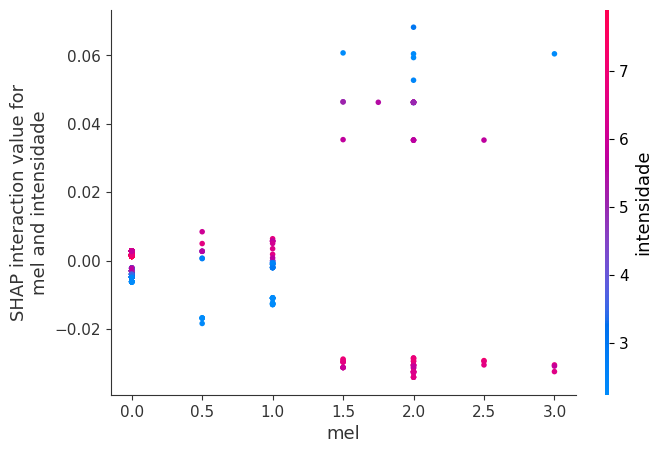

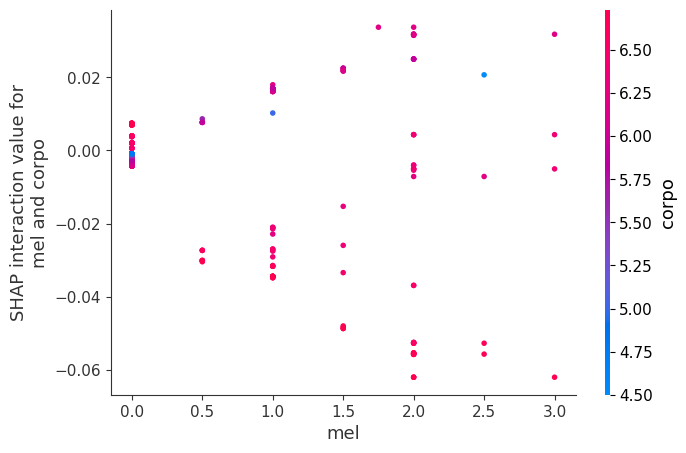

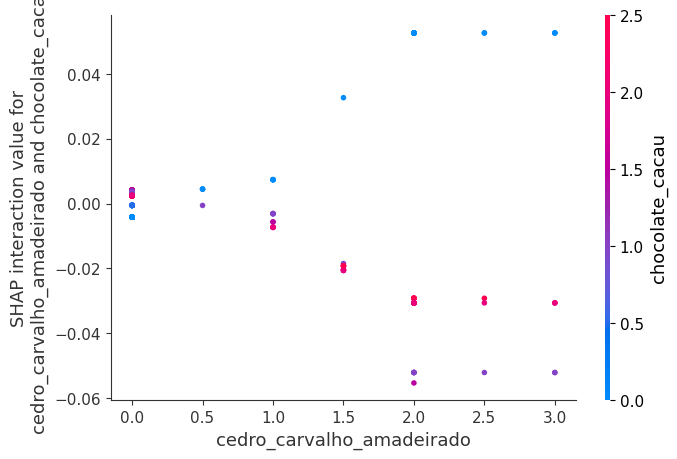

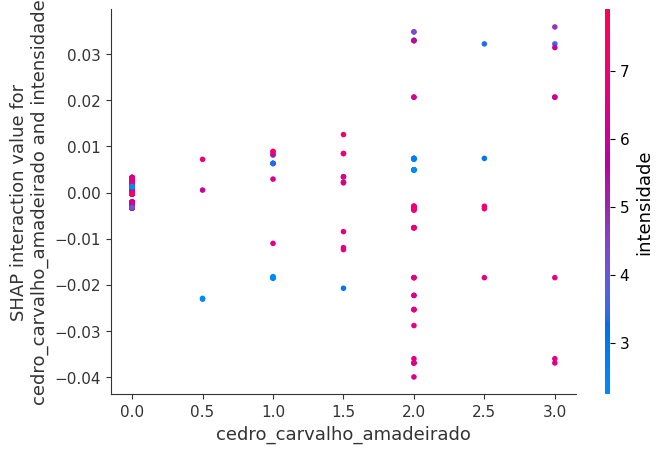

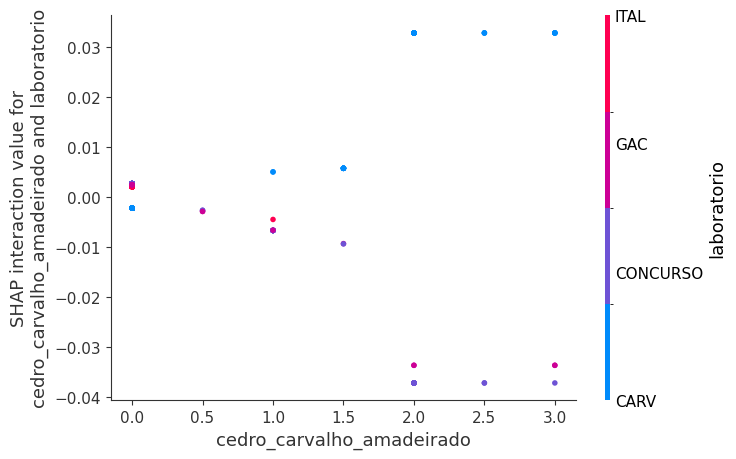

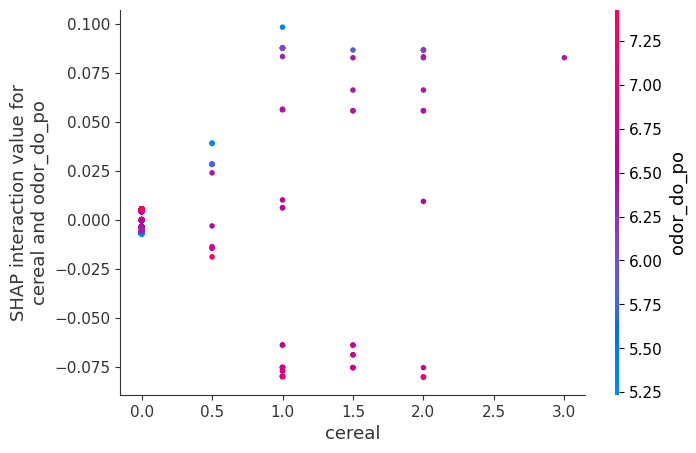

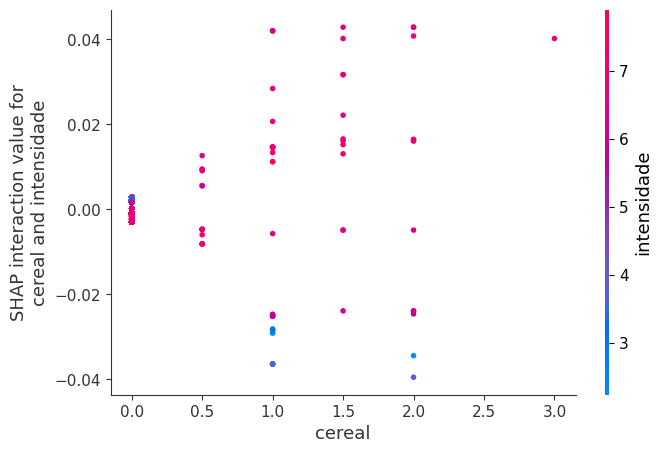

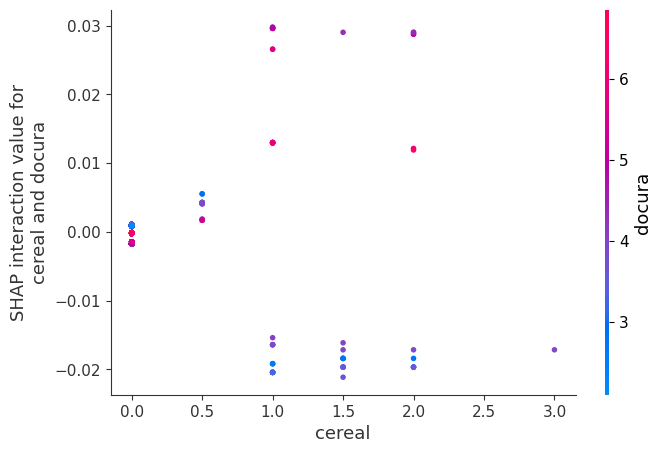

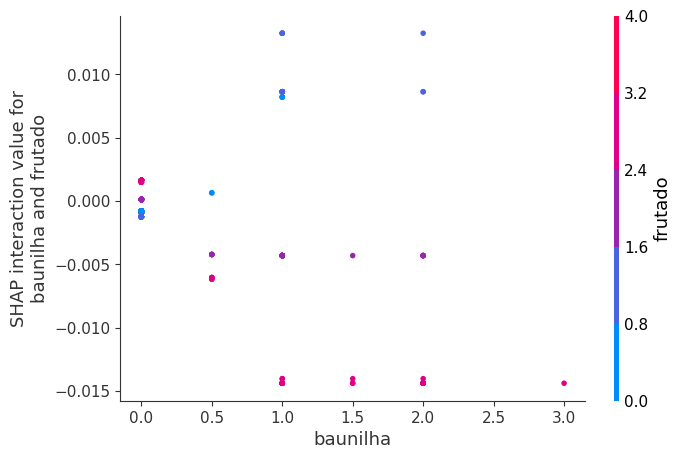

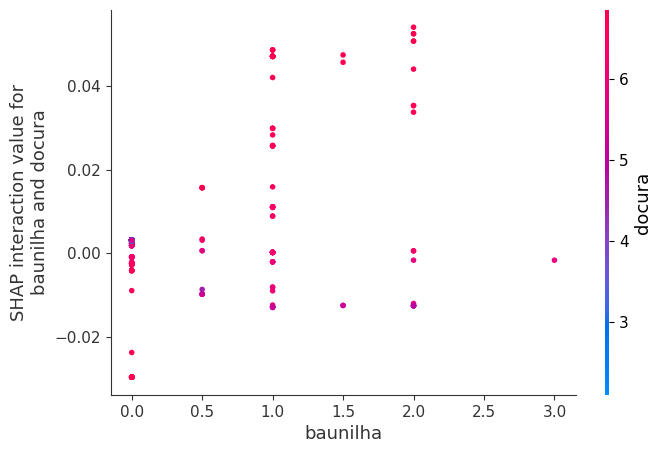

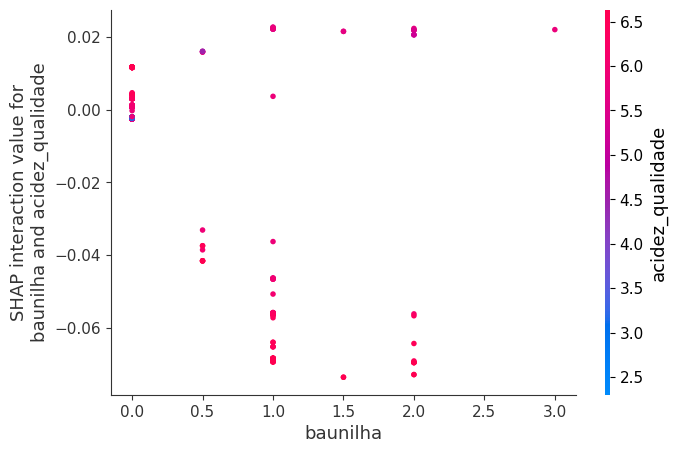

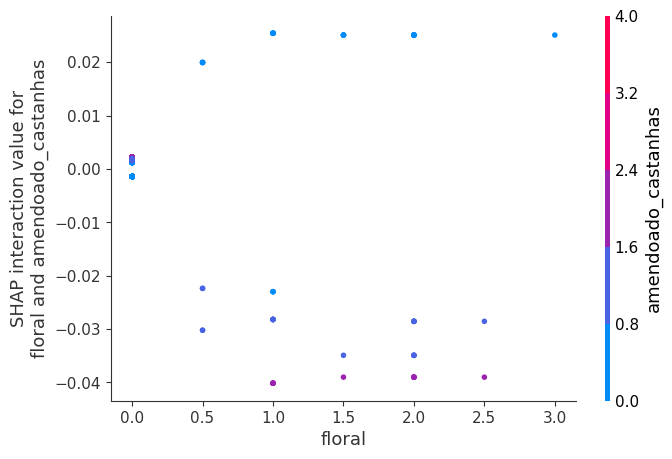

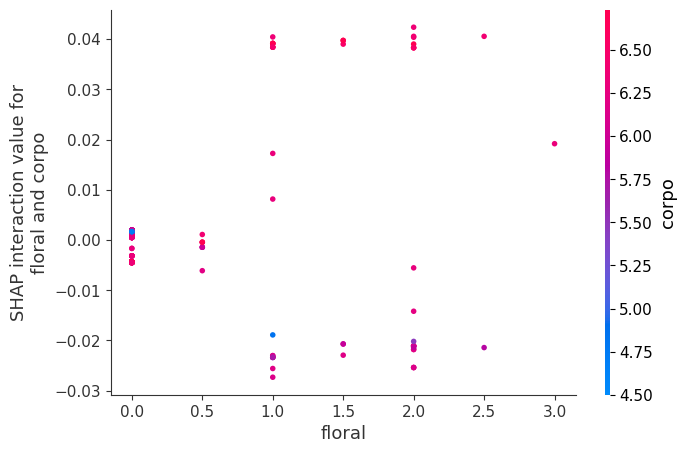

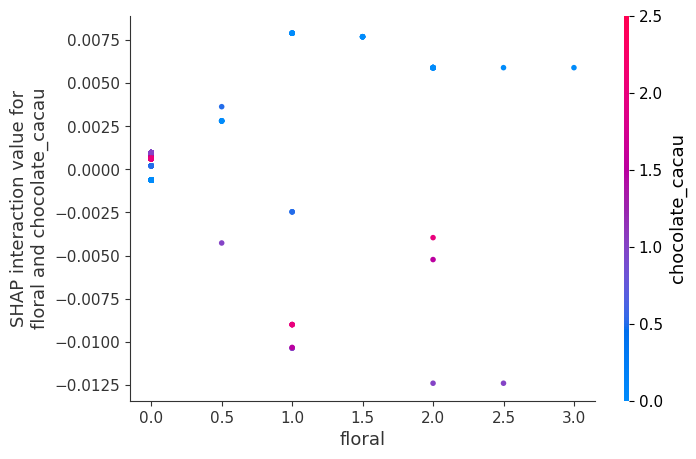

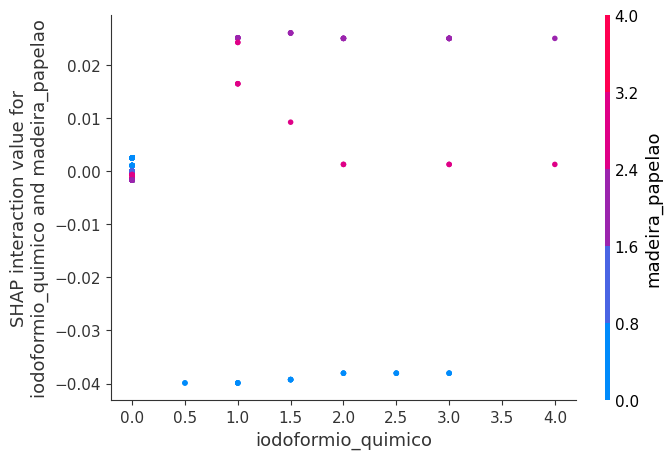

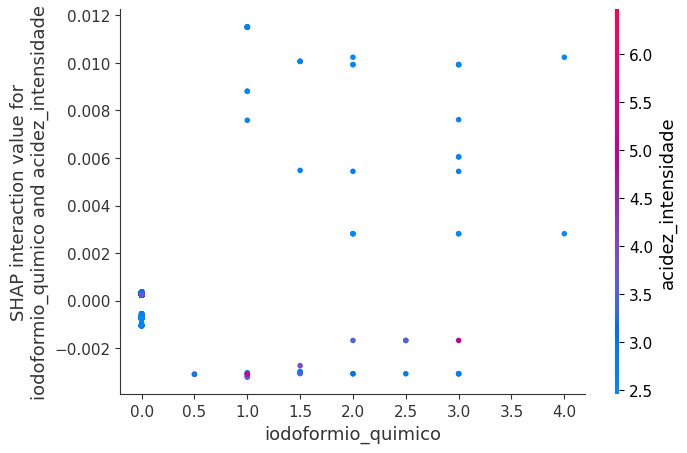

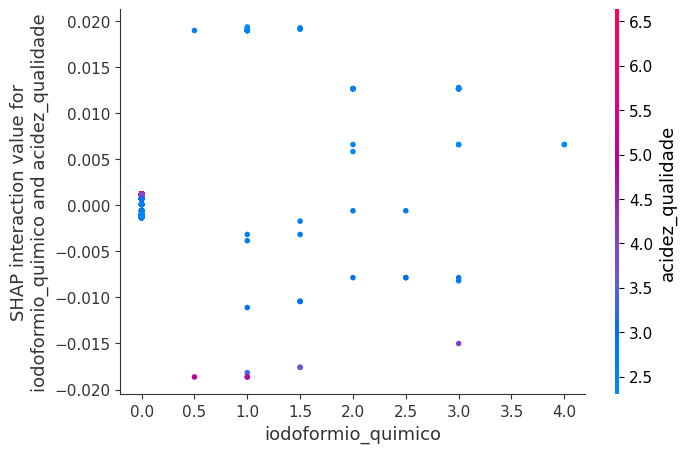

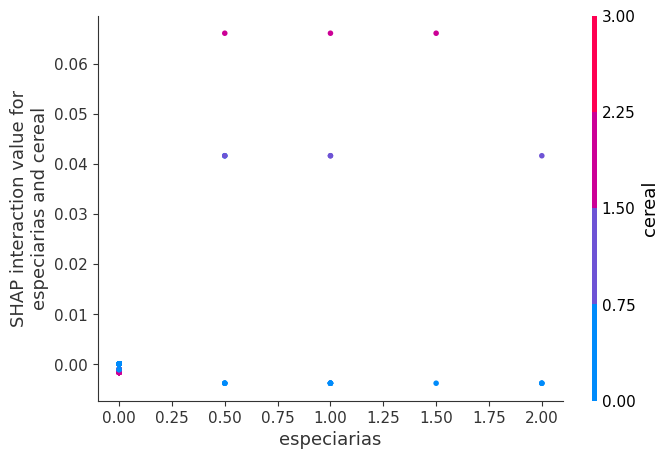

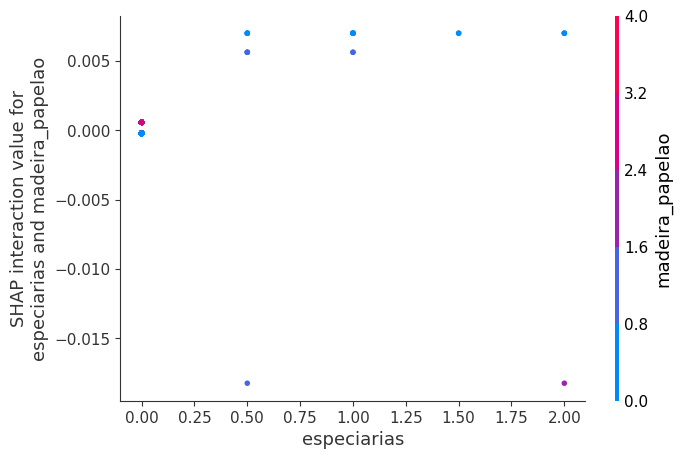

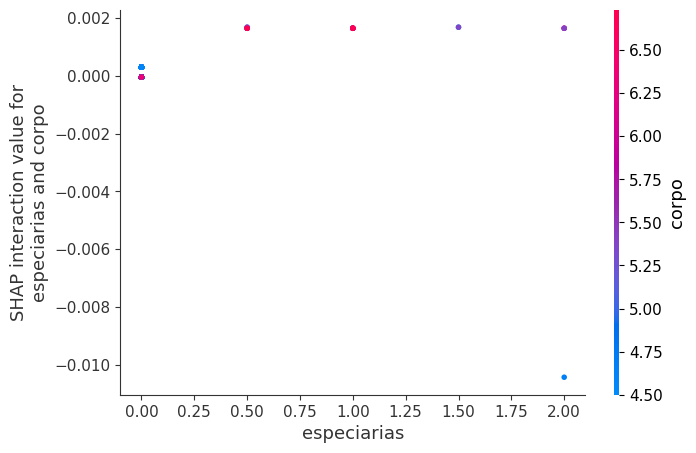

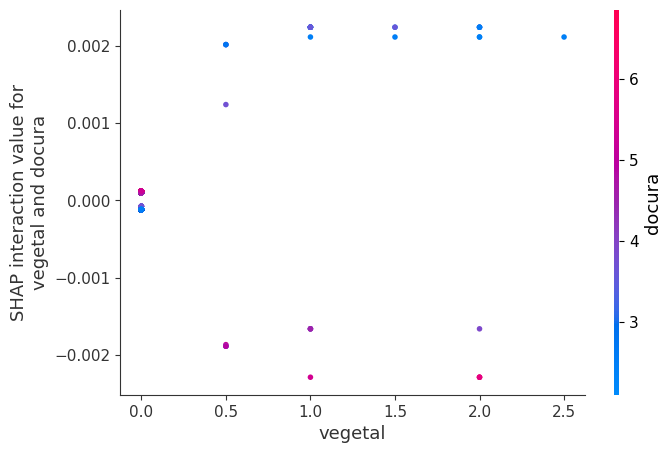

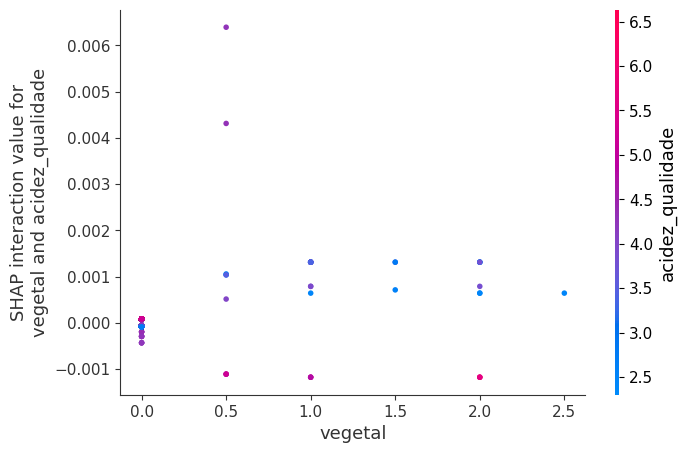

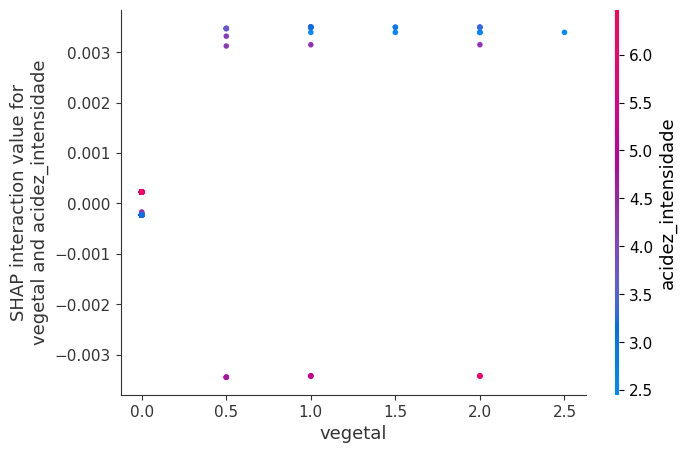

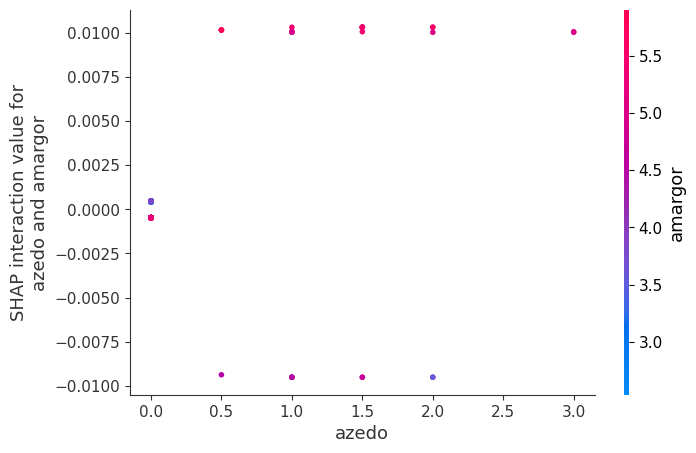

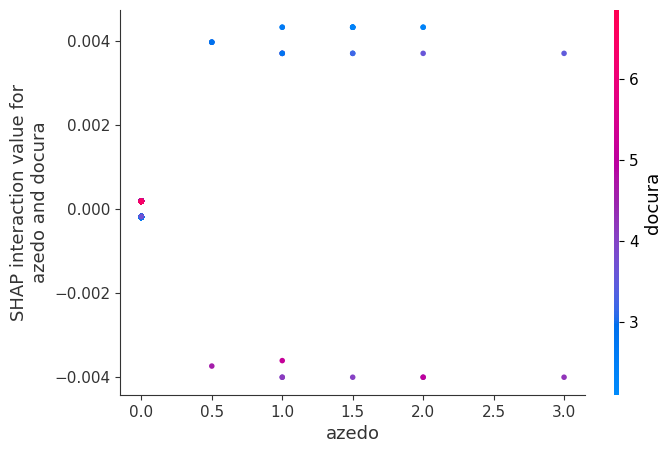

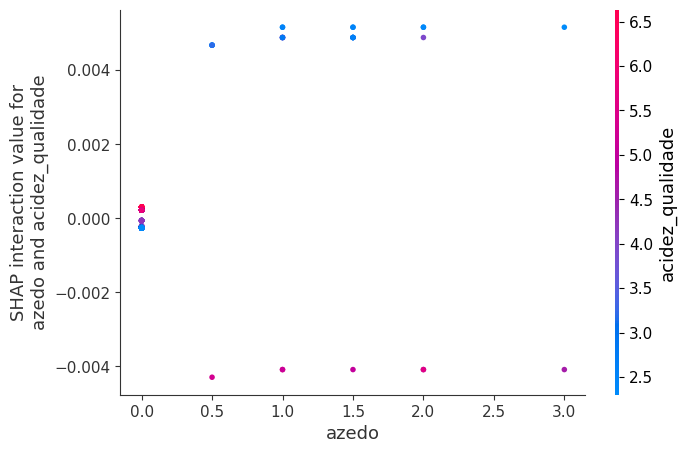

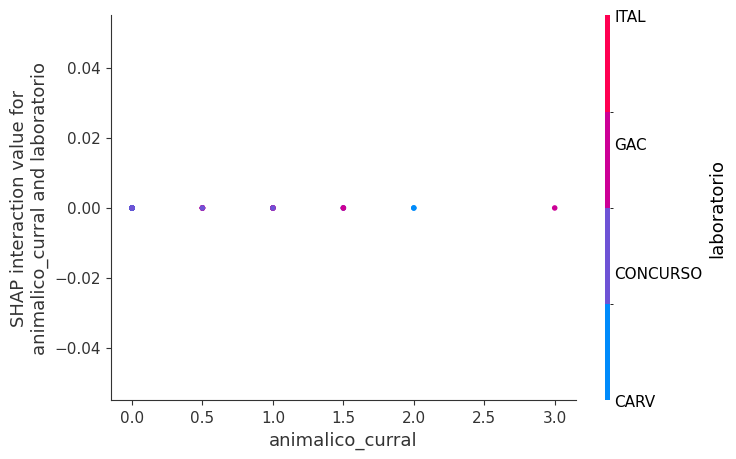

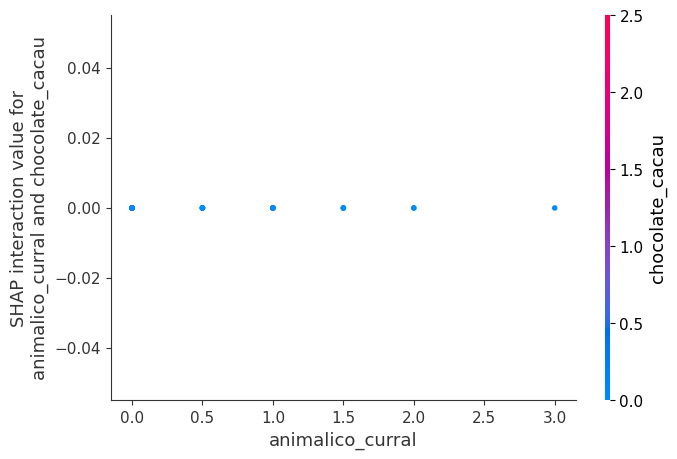

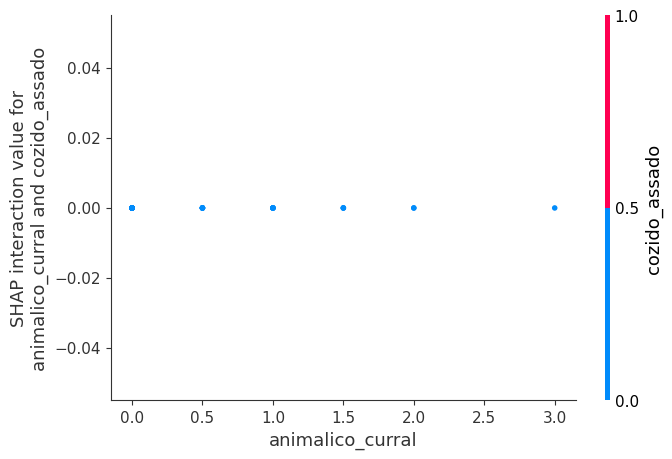

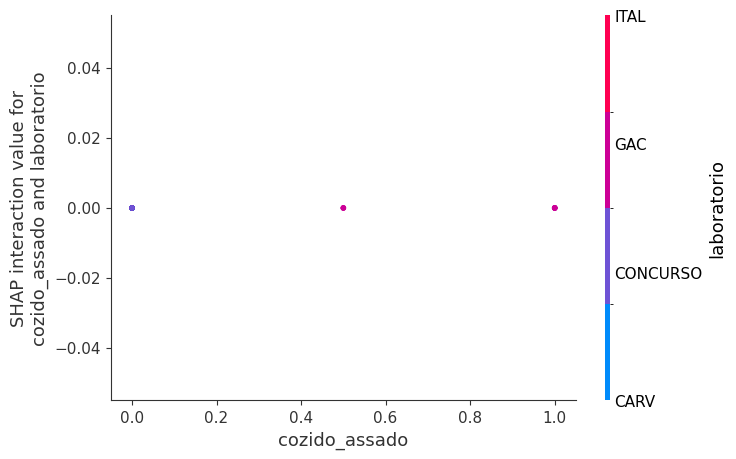

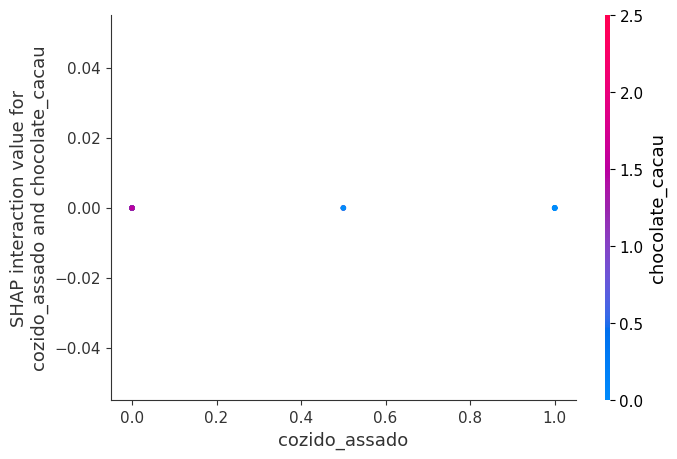

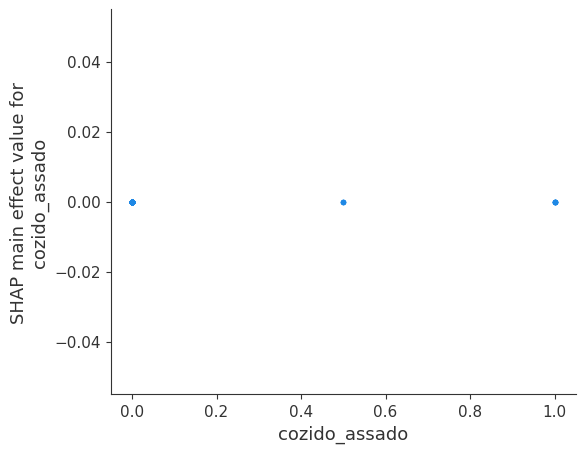

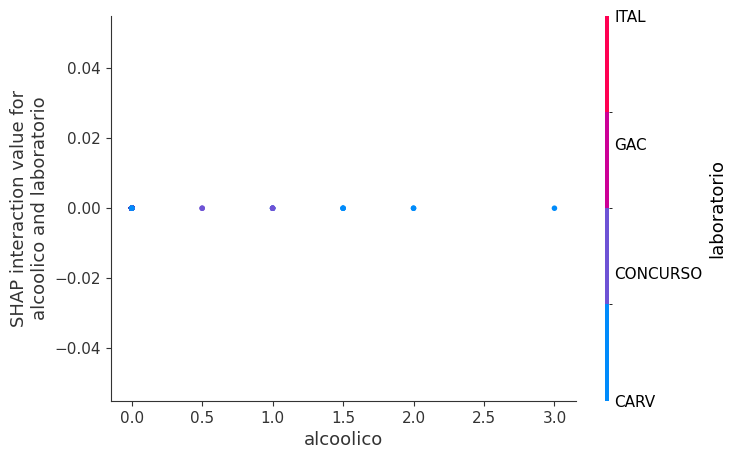

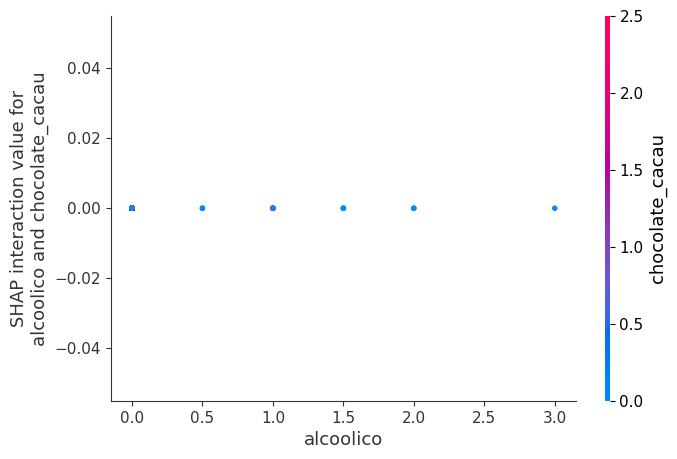

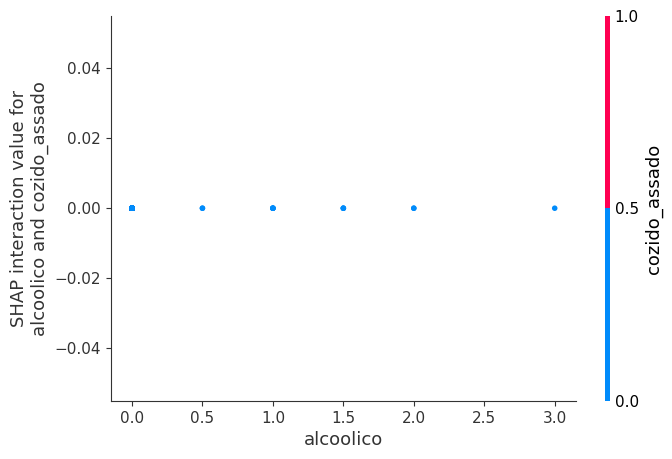

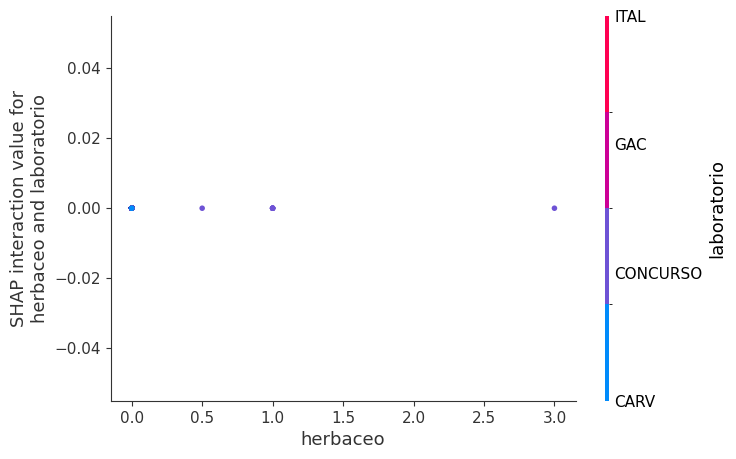

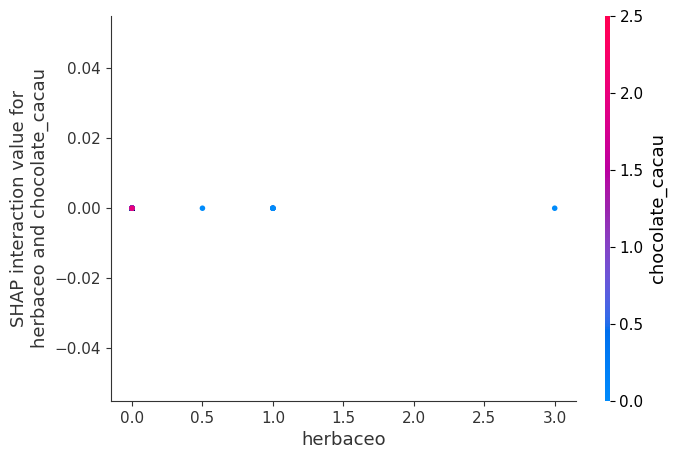

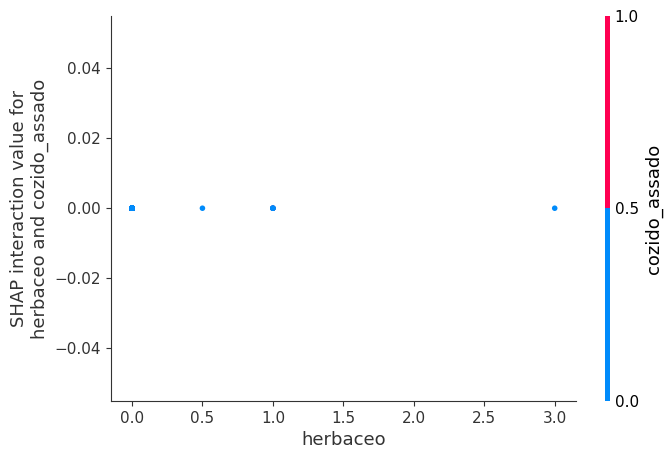

In [35]:


for col in int_imp.index.values:
   for i in range(3):
      index = int_order[col][i]
      int_var = trn_data.columns[index]
      
      shap.dependence_plot((col,int_var) , shap_interaction_values, trn_data)

In [36]:
int_var

'cozido_assado'

In [37]:
shap_vals

array([[-0.01400772,  0.00259358, -0.06097107, ..., -0.00985768,
        -0.00271684,  0.        ],
       [-0.01646508,  0.00211494, -0.0896424 , ..., -0.00604729,
        -0.00467948,  0.        ],
       [-0.00541942,  0.00207648, -0.01049571, ..., -0.00740692,
        -0.00505513,  0.        ],
       ...,
       [ 0.01536839, -0.01176637, -0.05332756, ...,  0.00238393,
        -0.00027996,  0.        ],
       [ 0.07431789, -0.00281675, -0.01036075, ...,  0.01971   ,
        -0.00617977,  0.        ],
       [ 0.04017189, -0.01121091, -0.01073077, ...,  0.06009031,
        -0.00164705,  0.        ]])